# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:
-	id — номер записи;
-	adults — количество взрослых постояльцев;
-	arrival_date_year — год заезда;
-	arrival_date_month — месяц заезда;
-	arrival_date_week_number — неделя заезда;
-	arrival_date_day_of_month — день заезда;
-	babies — количество младенцев;
-	booking_changes — количество изменений параметров заказа;
-	children — количество детей от 3 до 14 лет;
-	country — гражданство постояльца;
-	customer_type — тип заказчика: 
>	Contract — договор с юридическим лицом;
>	Group — групповой заезд;
>	Transient — не связано с договором или групповым заездом;
>	Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
-	days_in_waiting_list — сколько дней заказ ожидал подтверждения;
-	distribution_channel — канал дистрибуции заказа;
-	is_canceled — отмена заказа;
-	is_repeated_guest — признак того, что гость бронирует номер второй раз;
-	lead_time — количество дней между датой бронирования и датой прибытия;
-	meal — опции заказа: 
>	SC — нет дополнительных опций;
>	BB — включён завтрак;
>	HB — включён завтрак и обед;
>	FB — включён завтрак, обед и ужин.
-	previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
-	previous_cancellations — количество отменённых заказов у клиента;
-	required_car_parking_spaces — необходимость места для автомобиля;
-	reserved_room_type — тип забронированной комнаты;
-	stays_in_weekend_nights — количество ночей в выходные дни;
-	stays_in_week_nights — количество ночей в будние дни;
-	total_nights — общее количество ночей;
-	total_of_special_requests — количество специальных отметок.

**План работ:**
- Изучений файлов с данными
- Предобработка и исследовательский анализ данных
- Вычисление бизнес-метрики
- Разработка модели ML
- Выявить признаки «ненадёжного» клиента



### Шаг 1. Откройте файлы с данными

In [2]:
# в веб версии отсутвует по умолчанию библиотека phik
# скачаем её
!pip install phik

In [3]:
# в веб версии отсутвует по умолчанию библиотека imblearn
# скачаем её
! pip install imblearn

In [4]:
# загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import phik

import warnings
warnings.filterwarnings("ignore")

from collections import Counter

from phik.report import plot_correlation_matrix

from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, \
    precision_score, recall_score, confusion_matrix, \
    mean_squared_error, roc_auc_score, roc_curve, \
    balanced_accuracy_score

from sklearn.utils import shuffle

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)




In [5]:
# сохраним тренировочный и тестовый датасет в переменные

try:
    train = pd.read_csv('/datasets/hotel_train.csv')
    test = pd.read_csv('/datasets/hotel_test.csv')
except:
    train = pd.read_csv('hotel_train.csv')
    test = pd.read_csv('hotel_test.csv')

In [6]:
# проверка на корректное открытие
display(train.head(5))
display(test.head(5))

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


**Вывод:** Предоставленные датасеты были загружены в переменные train (для обучения модели) и test (для её тестирования).

### Шаг 2. Предобработка и исследовательский анализ данных

In [7]:
def base_analizez(data):
    ''' функция для изучения датасета'''
    
    print('Просмотр датасета:')
    display(data.head())
    
    print('\n')
    print('Общая информация об датасете:')
    print(data.info())
    
    print('\n')
    print('Проверка на наличие значений nan в датасете:')
    display(pd.DataFrame(round(
        data.isna().mean()*100,)).style.background_gradient('coolwarm'))
    
    print('\n')
    print('Изучение корреляции между данными')
    
    # Т.к. в датасете присутствует большое количество категориальных 
    # переменных применим метрику Phik (φk) корреляции. 
    
    phik_overview = data.phik_matrix()
    
    plot_correlation_matrix(phik_overview.values.round(2), 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 8))
    plt.tight_layout()
    

Просмотр датасета:


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3




Общая информация об датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  

,0
id,0.000000
is_canceled,0.000000
lead_time,0.000000
arrival_date_year,0.000000
arrival_date_month,0.000000
arrival_date_week_number,0.000000
arrival_date_day_of_month,0.000000
stays_in_weekend_nights,0.000000
stays_in_week_nights,0.000000
adults,0.000000




Изучение корреляции между данными
interval columns not set, guessing: ['id', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']


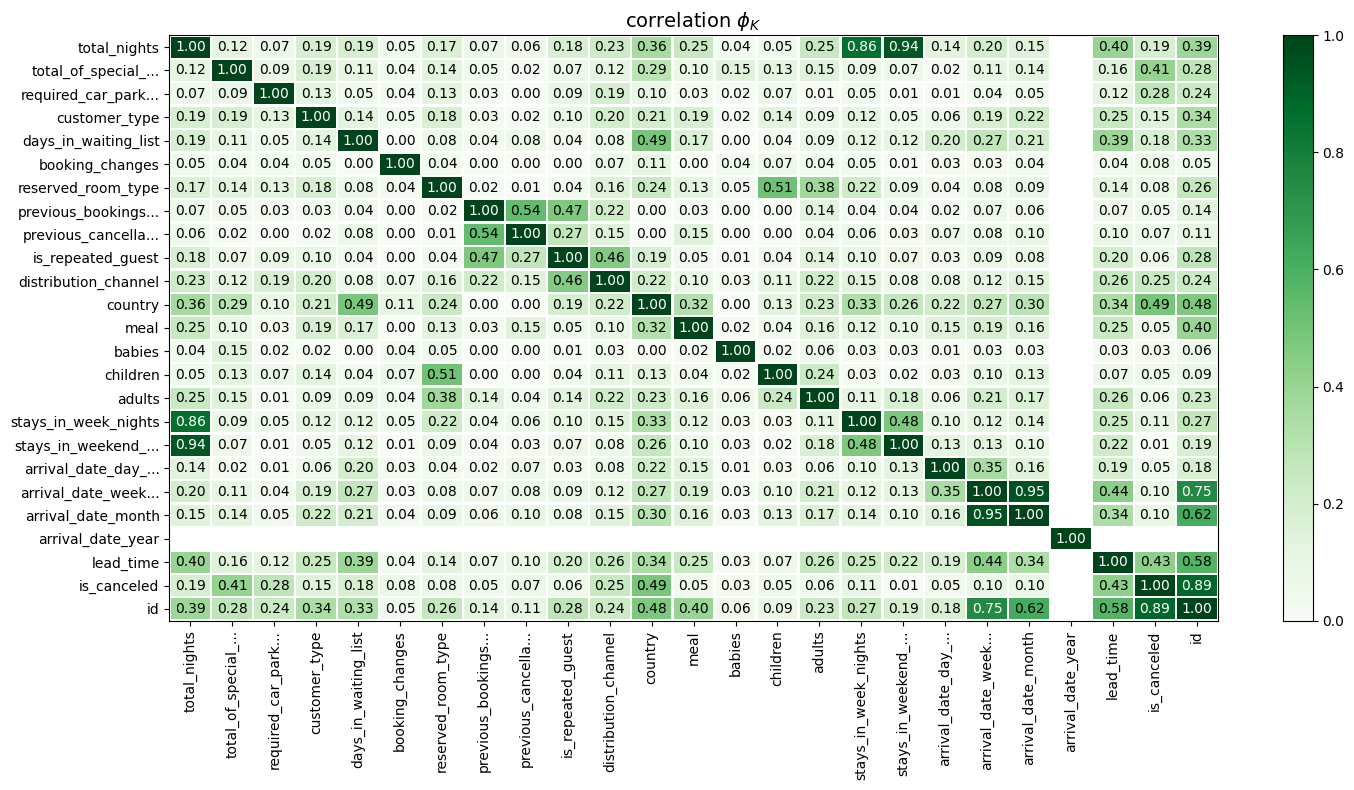

In [8]:
base_analizez(train)

Просмотр датасета:


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7




Общая информация об датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  

,0
id,0.000000
is_canceled,0.000000
lead_time,0.000000
arrival_date_year,0.000000
arrival_date_month,0.000000
arrival_date_week_number,0.000000
arrival_date_day_of_month,0.000000
stays_in_weekend_nights,0.000000
stays_in_week_nights,0.000000
adults,0.000000




Изучение корреляции между данными
interval columns not set, guessing: ['id', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']


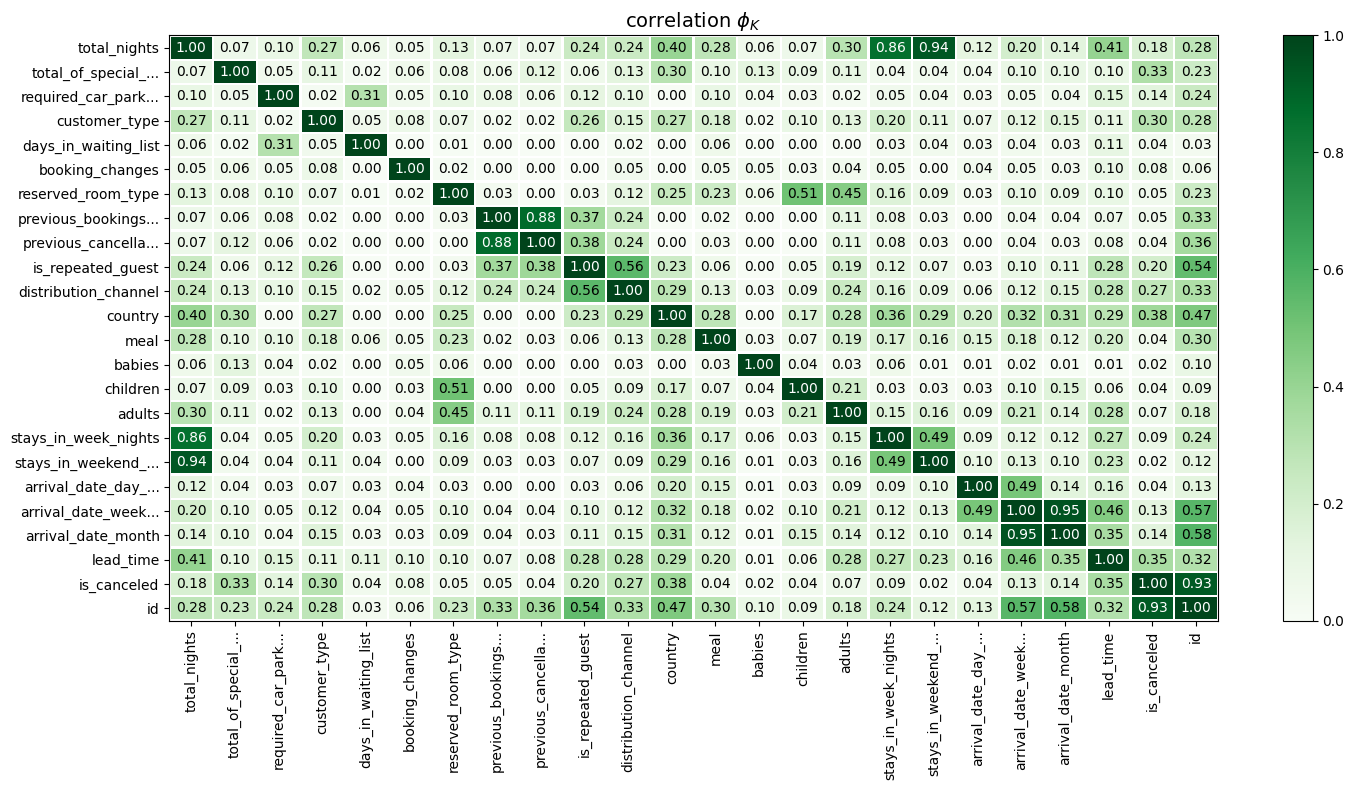

In [9]:
base_analizez(test)

Из матриц кореляции видна взаимосвязь между колонками связанными с датами arrival_date_week_number,arrival_date_month, arrival_date_year. В колонках связанными с кол-вом дней проживания total_nights, stays_in_weekend_nights, stays_in_week_nights. Данные признаки отчасти дублируют друг друга, из-за чего возникает ложная корреляция. В дальнейшем для более точной работы модели некоторые дублирующие колонки необходимо будет удалить. 

In [10]:
# изучение уникальных значений в датасетe train
for i in train.columns:
    print(i, '-----------------------------')
    print(train[i].unique())

id -----------------------------
[    0     1     2 ... 84094 84117 84121]
is_canceled -----------------------------
[0 1]
lead_time -----------------------------
[  7.  14.   0.   9.  85.  75.  23.  18.  68.  37.  72.  48.  77.  99.
  40.  15.  36.  70.  45.  16. 107.  47.  96. 113.  50.   3.   1.  10.
   5.  17.  93.  71.  63.  62. 101.   2.  81.  12. 109. 102.   4.  92.
  95.  86.  78.  29.  30.  51.  33.   8. 100.  80.  97.  64.  90.  27.
  82.  94. 115. 111.  98.  66. 104.  65.  55.  21.  88.  43.  54. 280.
  24. 103. 249.  13.  79.  35.  31.  34.  44. 304. 117.  84. 110.  59.
 116.  91.  42.  60. 321.  32.  56.  41.  76.  49.  73. 112.  39.  58.
  57.  19.  53.  38.   6. 108.  26. 123.  28. 118.  46.  69.  52.  89.
  61.  22.  67. 105.  25.  11.  87. 299.  74. 298. 119.  20.  83. 136.
 129. 124. 130. 131. 139. 122. 106. 137. 120. 135. 150. 143. 151. 126.
 147. 128. 156. 132. 164. 159. 161. 333. 149. 154. 297. 163. 314. 323.
 340. 142. 302. 175. 166. 114. 140. 157. 310. 172. 145. 

In [11]:
# удаляем обнаруженные пробелы в train и переводим значения в int
train['reserved_room_type'] = train['reserved_room_type'].str.strip()
train['meal'] = train['meal'].str.strip()

train['adults'] = train['adults'].astype('int')
train['children'] = train['children'].astype('int')
train['babies'] = train['babies'].astype('int')


In [12]:
# изучение уникальных значений в датасетe test
for i in test.columns:
    print(i, '-----------------------------')
    print(test[i].unique())

id -----------------------------
[ 6086  6087  6088 ... 97901 97902 97903]
is_canceled -----------------------------
[1 0]
lead_time -----------------------------
[ 74.  62.  71. 172.  52. 143.  21.  89.  48.  31.  20. 173.  23.  46.
 149.  44.  68.   6.  43. 112.  59.  93.   4. 115. 187.  11.   2.  15.
  66. 113. 125. 161. 154.   1.   0.  35.  37.  60. 129.  78.  10.  82.
   8.  22.  33. 108.  87. 106.  45.  40.  17.   5.  16.   3.  41. 135.
 123. 128.  47.  12. 124. 160.  58.  65. 281.  24.  30.  27.   9.  94.
 219.  84.  79.  72.  36. 292. 186.  85. 169. 166.  28.  83. 111.  54.
 200.  80. 102.  95. 170. 307. 298.  55.  77.  32.  25. 238.   7.  19.
 211. 137.  39.  18. 206.  42. 179. 205. 142.  38.  92.  56.  29. 119.
  73. 320.  34. 127.  69.  13. 140.  14. 164.  51.  70. 120.  76. 105.
  50. 191.  26.  75. 116. 184.  53.  49.  63. 194. 167. 312. 171. 218.
  86. 100. 146.  64. 148.  81.  88.  57. 339. 332. 133. 208.  61. 177.
 157. 278. 285. 210. 232. 139. 134. 204. 201. 216. 340. 

In [13]:
# удаляем обнаруженные пробелы в test и переводим значения в int
test['reserved_room_type'] = test['reserved_room_type'].str.strip()
test['meal'] = test['meal'].str.strip()

test = test.astype({'lead_time': 'int64', 'adults': 'int64','children': 'int64',
             'babies': 'int64'})


Для базисного исследования основных закономерностей в данных, по мимо изучения корреляции между параметрами, изучим зависимость кол-во отмененных заказов по 4 колонкам reserved_room_type, arrival_date_month, lead_time, total_nights. P.S. В данную случае выбрал 4 колонки ввиду того, что в датасете присутствует огромное кол-во разнообразных колонок, а указанные для исследования колонки могут отобразить самые популярные тенденции.

In [14]:
def view_data(data, column):
    
    """Функция для построения графиков отмены и не отмены брони
    по выбранной колонке (группировке)"""
    
   
    #количество отмен брони по определенной колонке
    type_1 = data.loc[train['is_canceled'] == 1].groupby(
        column).agg({'is_canceled': 'count'})
    
    #количество не отмененной брони по определенной колонке
    type_0 = data.loc[train['is_canceled'] == 0].groupby(
        column).agg({'is_canceled': 'count'})

    print('Отмена броинрования по каждой группе:')
    display(type_1)
    
#   построение гистограмм
    plt.bar(type_1.index, type_1['is_canceled'], color = 'red', alpha=.8)
    plt.bar(type_0.index, type_0['is_canceled'], color = 'green',alpha=.4)
#     plt.hist(type_0, color = 'green', alpha=0.6)
#     type_1.plot(kind= 'hist', color = 'red')
#     type_0.plot(kind= 'hist', color = 'green')
    
    plt.legend(('Отмена брони', 'Отмены не было'))
    title = f"Кол-во отмены бронирования в зависимости от {column}"
    
    plt.title(title)
    
#     Общее количество заказов по выбранной группировки
    total = data.groupby(column).agg({'is_canceled': 'count'})
    
    print('Бронирование по каждой группе:')
    display(total)
    
#     график процентов общей отмены заказов от кол-ва всего

    ((type_1 / total) * 100).plot(kind = 'bar',
                        grid = True,figsize = (12,6),
                        title = 'Процент отмены брони от общего кол-ва')
    
    plt.figsize = (12,6)
    plt.show()
    
    
    

Тренировочная выборка
Отмена броинрования по каждой группе:


,is_canceled
reserved_room_type,
A,19722
B,261
C,43
D,2871
E,608
F,348
G,191


Бронирование по каждой группе:


,is_canceled
reserved_room_type,
A,50501
B,860
C,228
D,9387
E,2448
F,1213
G,592


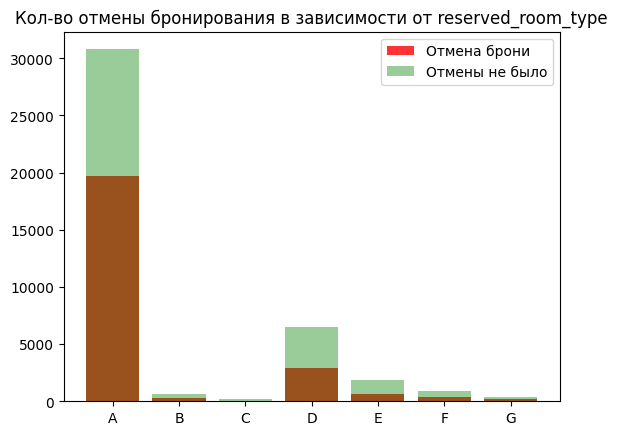

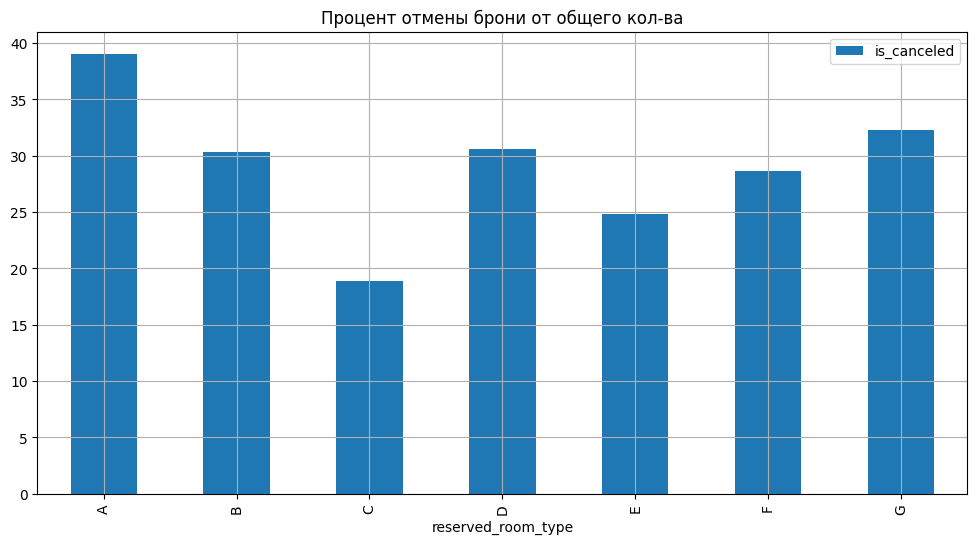

Тестовая выборка
Отмена броинрования по каждой группе:


,is_canceled
reserved_room_type,
A,10192
B,87
C,86
D,3039
E,844
F,243
G,163


Бронирование по каждой группе:


,is_canceled
reserved_room_type,
A,23471
B,192
C,201
D,6123
E,1644
F,503
G,278


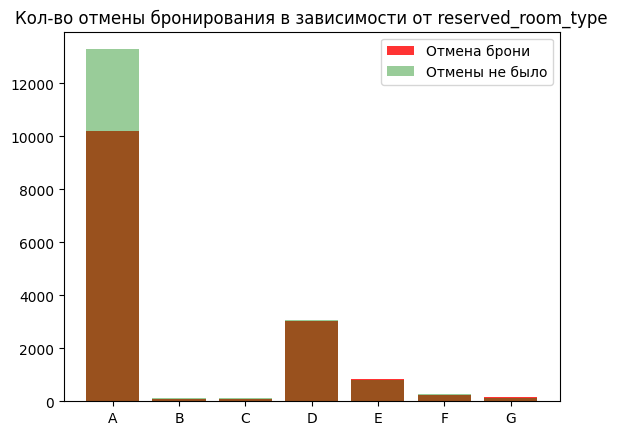

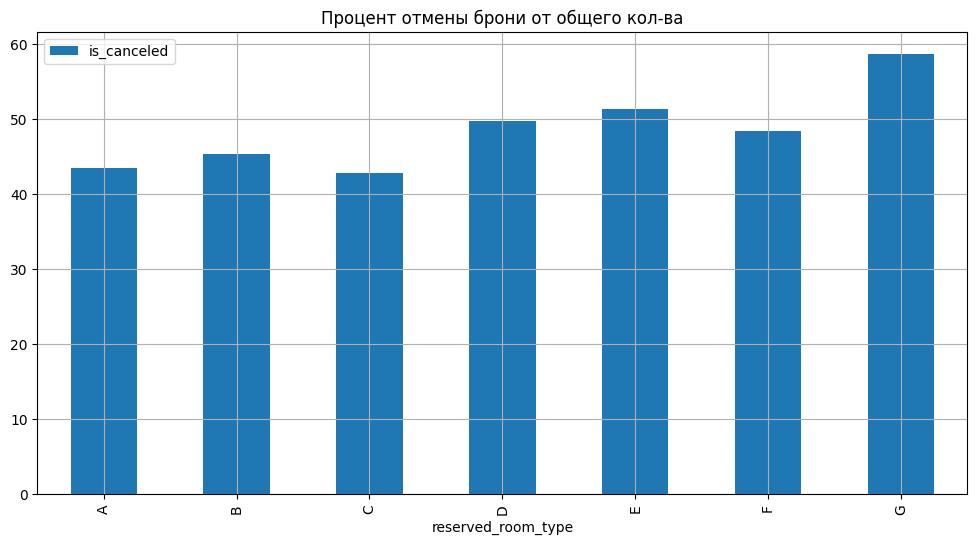

In [15]:
print('Тренировочная выборка')
view_data(train, 'reserved_room_type')
print('Тестовая выборка')
view_data(test, 'reserved_room_type')

Тренировочная выборка
Отмена броинрования по каждой группе:


,is_canceled
arrival_date_month,
April,1886
August,2597
December,1913
February,1182
January,487
July,2221
June,1931
March,1277
May,1673


Бронирование по каждой группе:


,is_canceled
arrival_date_month,
April,4804
August,6678
December,5497
February,3358
January,1892
July,5718
June,4659
March,4148
May,4677


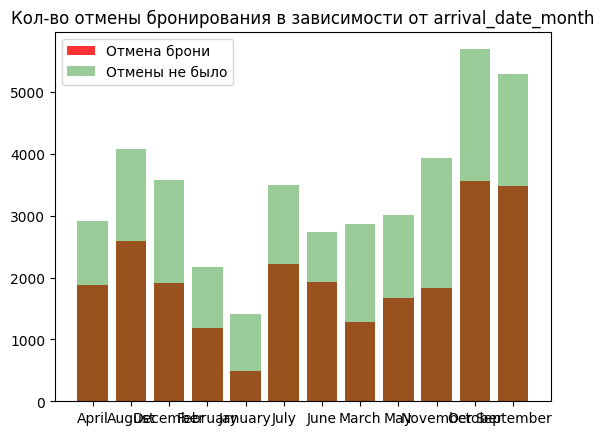

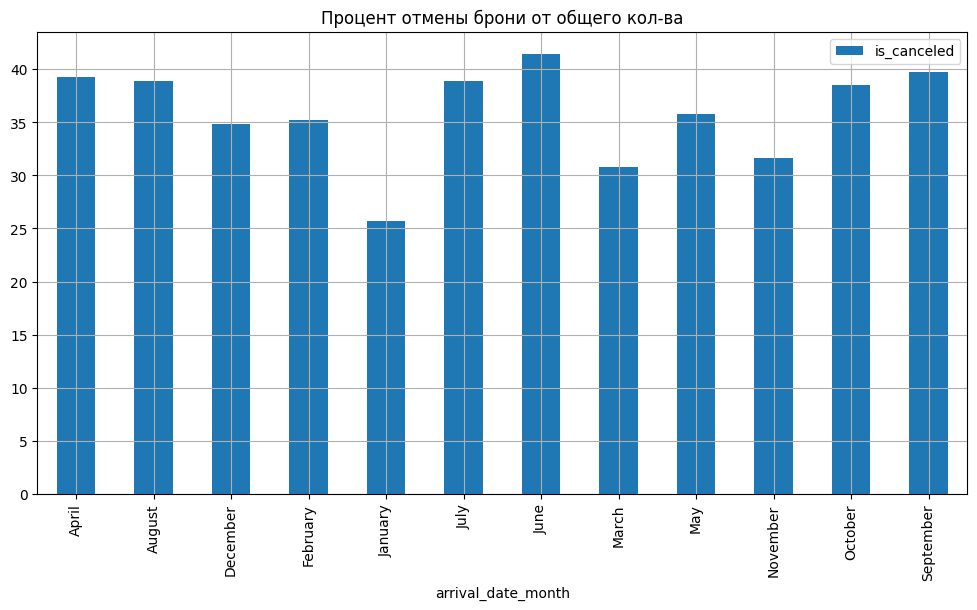

Тестовая выборка
Отмена броинрования по каждой группе:


,is_canceled
arrival_date_month,
April,2251
August,1964
February,1370
January,948
July,2105
June,1993
March,1587
May,2436


Бронирование по каждой группе:


,is_canceled
arrival_date_month,
April,4878
August,3096
February,3543
January,3150
July,3626
June,4580
March,4277
May,5262


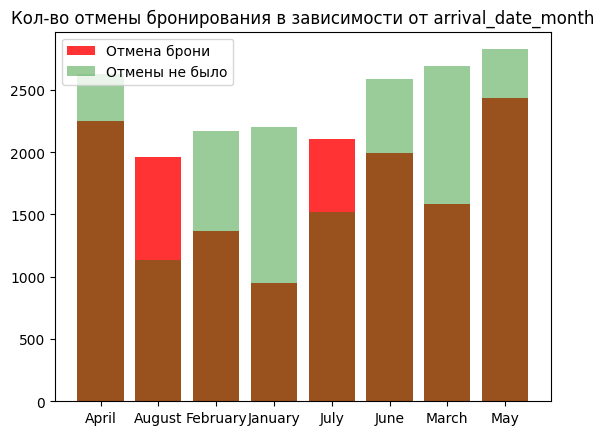

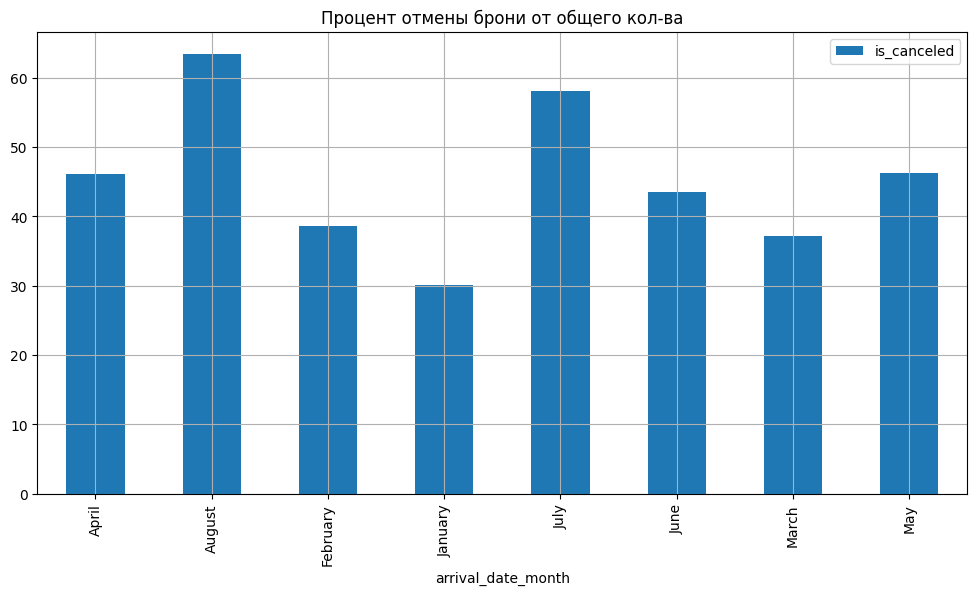

In [16]:
print('Тренировочная выборка')
view_data(train, 'arrival_date_month')
print('Тестовая выборка')
view_data(test, 'arrival_date_month')

Тренировочная выборка
Отмена броинрования по каждой группе:


,is_canceled
total_nights,
1,3102
2,7577
3,6290
4,3372
5,1342
6,852
7,1227
8,183
9,61


Бронирование по каждой группе:


,is_canceled
total_nights,
1,12122
2,16795
3,15652
4,9629
5,4288
6,2078
7,3853
8,542
9,152


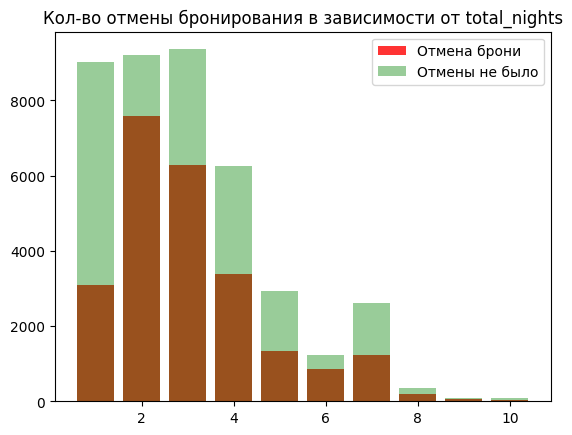

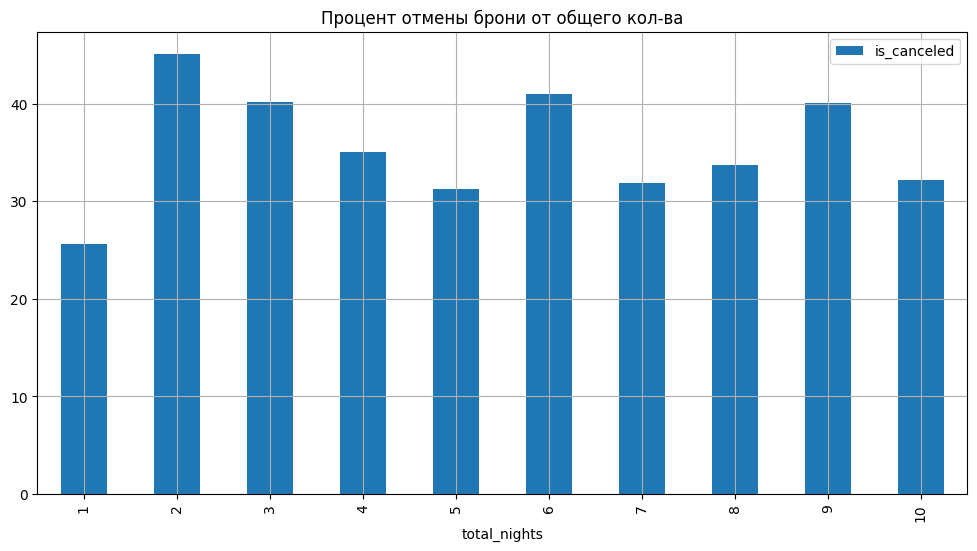

Тестовая выборка
Отмена броинрования по каждой группе:


,is_canceled
total_nights,
1,2763
2,2869
3,3484
4,2645
5,1123
6,443
7,1160
8,105
9,37


Бронирование по каждой группе:


,is_canceled
total_nights,
1,5465
2,6760
3,8395
4,5828
5,2409
6,939
7,2284
8,215
9,62


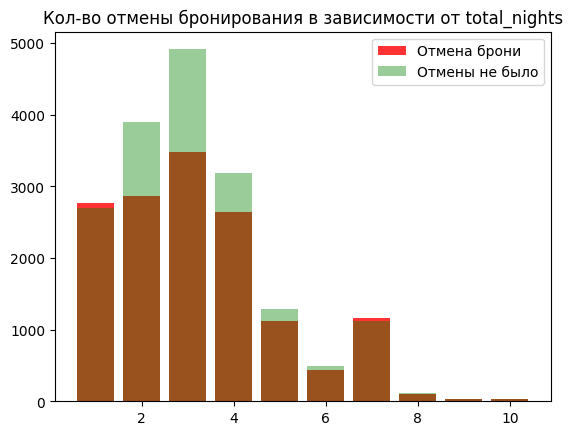

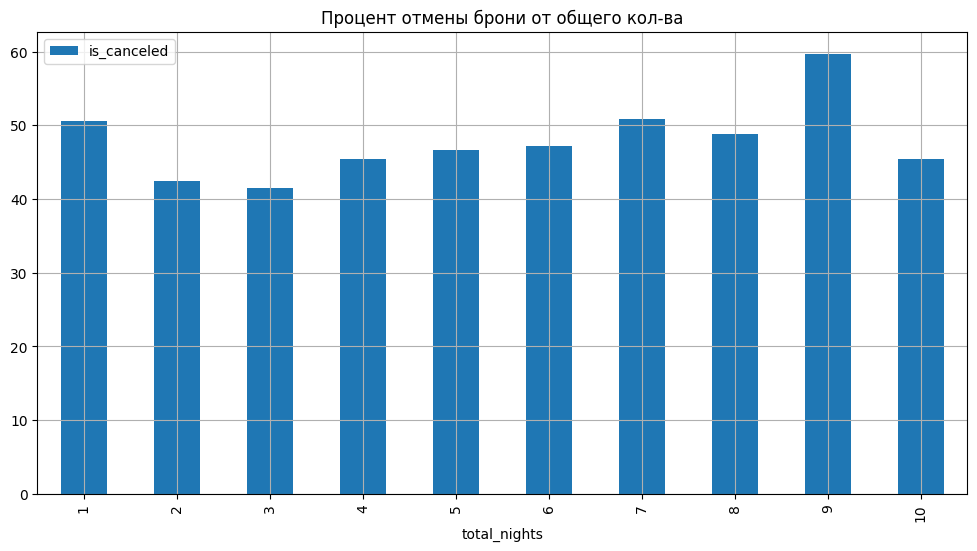

In [17]:
print('Тренировочная выборка')
view_data(train, 'total_nights')
print('Тестовая выборка')
view_data(test, 'total_nights')

In [18]:
# для колоник 'lead_time' создадим отдельный столбец
sort_series = train['lead_time']
sort_series = sort_series.sort_values().unique()
sort_series

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

Добавим в копию датасета стобец, к которому будет добавлена следующие категории:
>-Бронирование за 0-14 дней = 0-14_day

>Бронирование за 14-48 дней = 14-48_day

>Бронирование за 48-96 дней = 48-96_day

>Бронирование за 96-192 дней = 96-192_day

>Бронирование за 192-292 дней = 192-292_day

>Бронирование за 292-374 дней = 292-374_day



In [19]:
def replace_data(i, data,  type_group):
    '''замена пустых ячеек на значений'''
    data.loc[(data['lead_time'] == int(i), 'type_lead')] = type_group

In [20]:
# замена пустых значений в тестовом датасете на указанные группы

lead_train = train.copy() 
lead_train['type_lead'] = str('0')

for i in sort_series:

    if int(i)>= 0 and int(i) <= 14:
        replace_data(int(i), lead_train, '0-14_day')
    if int(i)> 14 and int(i) <= 48:
        replace_data(int(i), lead_train, '14-48_day')
    if int(i)> 48 and int(i) <= 96:
        replace_data(int(i), lead_train, '48-96_day')
    if int(i)> 96 and int(i) <= 192:
        replace_data(int(i), lead_train, '96-192_day')
    if int(i)> 192 and int(i) <= 292:
        replace_data(int(i), lead_train, '192-292_day')
    if int(i)> 292 and int(i) <= 374:
        replace_data(int(i), lead_train, '292-374_day')

            

In [21]:
# аналогичное действие для тестовой выборки
lead_test = test.copy()
lead_test['type_lead'] = str('0')

for i in sort_series:

    if int(i)>= 0 and int(i) <= 14:
        replace_data(int(i), lead_test, '0-14_day')
    if int(i)> 14 and int(i) <= 48:
        replace_data(int(i), lead_test, '14-48_day')
    if int(i)> 48 and int(i) <= 96:
        replace_data(int(i), lead_test, '48-96_day')
    if int(i)> 96 and int(i) <= 192:
        replace_data(int(i), lead_test, '96-192_day')
    if int(i)> 192 and int(i) <= 292:
        replace_data(int(i), lead_test, '192-292_day')
    if int(i)> 292 and int(i) <= 374:
        replace_data(int(i), lead_test, '292-374_day')


Тренировочная выборка
Отмена броинрования по каждой группе:


,is_canceled
type_lead,
0-14_day,2062
14-48_day,4221
192-292_day,4404
292-374_day,2802
48-96_day,4534
96-192_day,6021


Бронирование по каждой группе:


,is_canceled
type_lead,
0-14_day,15159
14-48_day,13181
192-292_day,7720
292-374_day,3697
48-96_day,11946
96-192_day,13526


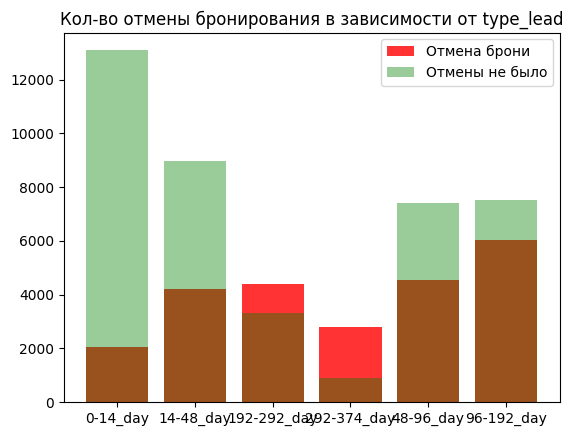

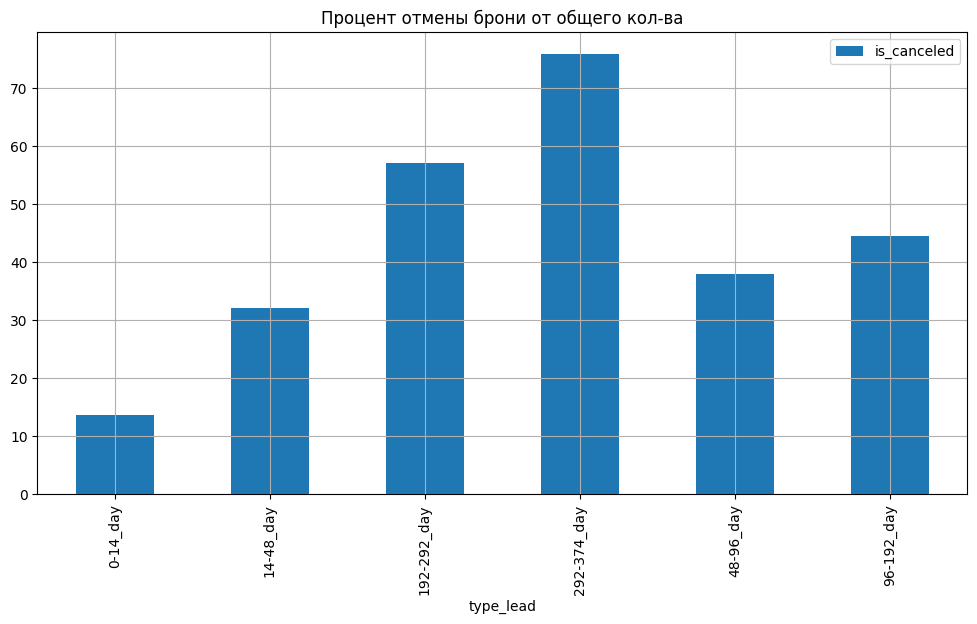

Тренировочная выборка
Отмена броинрования по каждой группе:


,is_canceled
type_lead,
0,8
0-14_day,3382
14-48_day,2774
192-292_day,1658
292-374_day,401
48-96_day,2459
96-192_day,3972


Бронирование по каждой группе:


,is_canceled
type_lead,
0,54
0-14_day,6291
14-48_day,6274
192-292_day,3712
292-374_day,1091
48-96_day,5847
96-192_day,9143


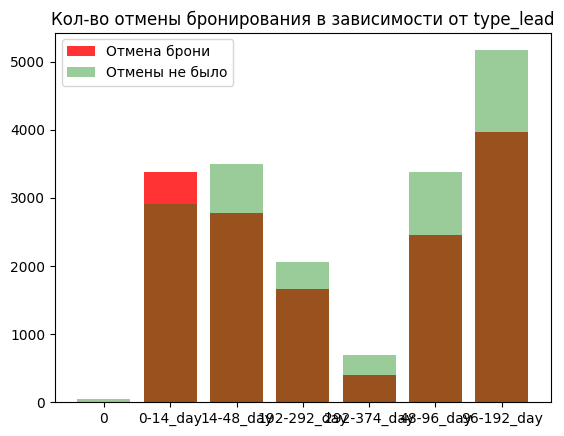

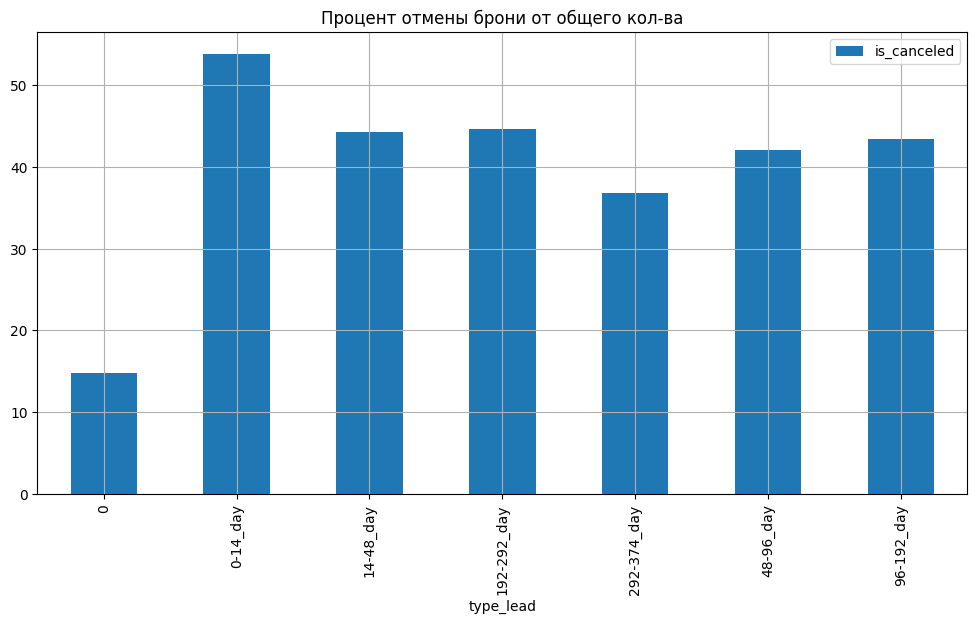

In [22]:
print('Тренировочная выборка')
view_data(lead_train, 'type_lead')
print('Тренировочная выборка')
view_data(lead_test, 'type_lead')

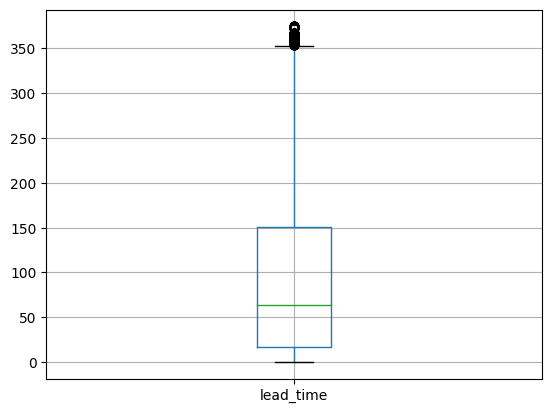

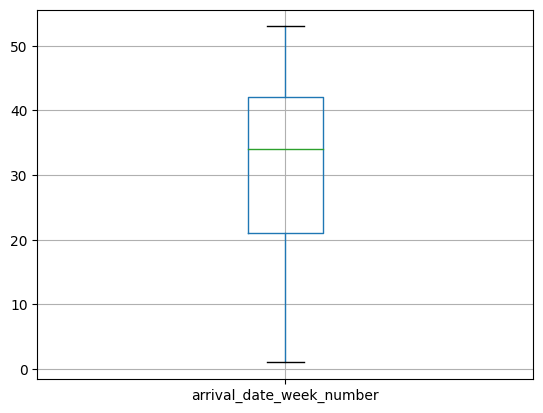

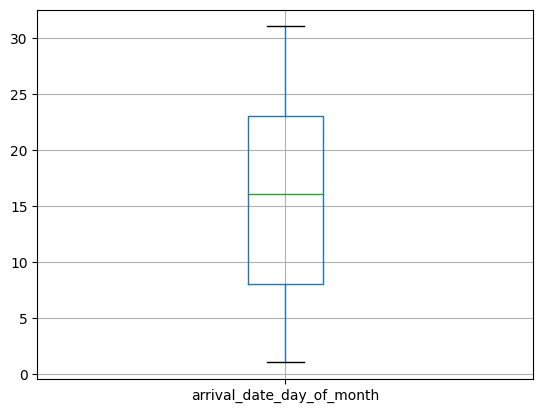

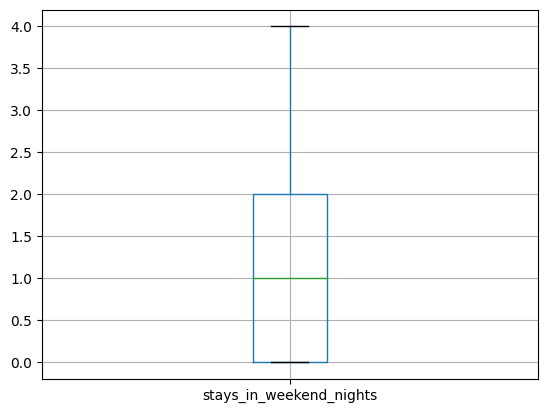

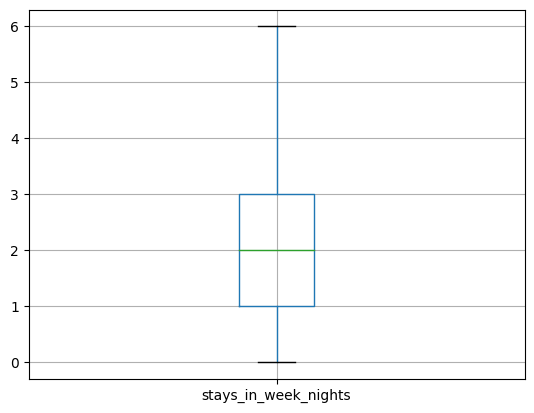

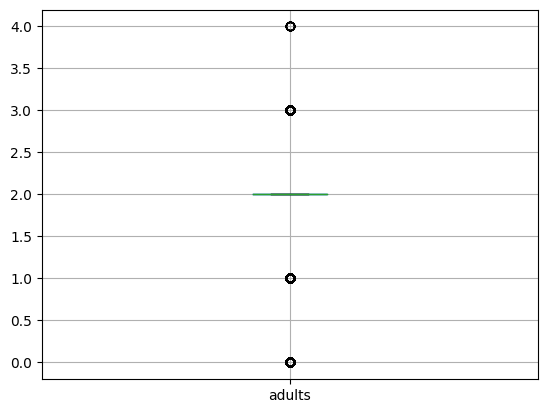

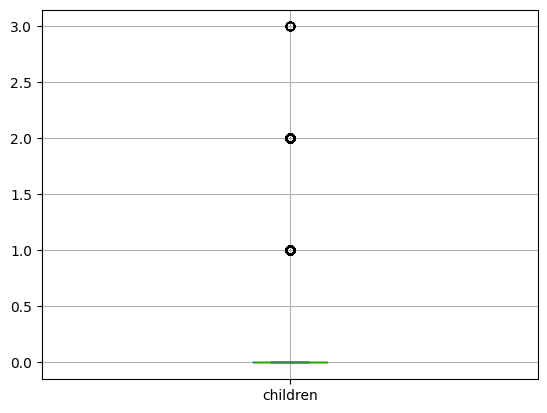

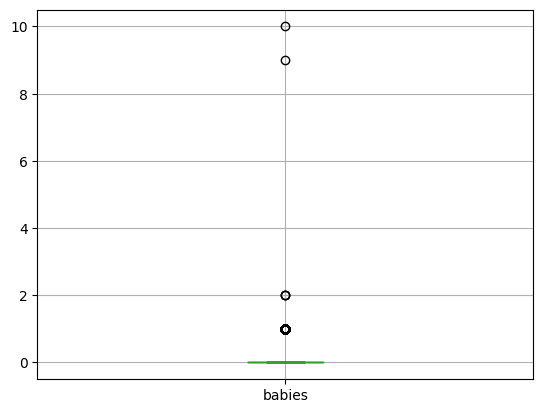

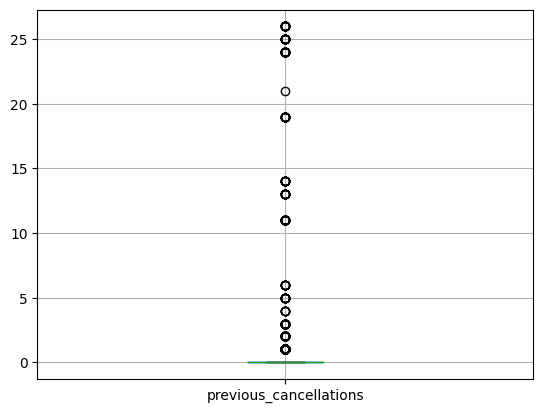

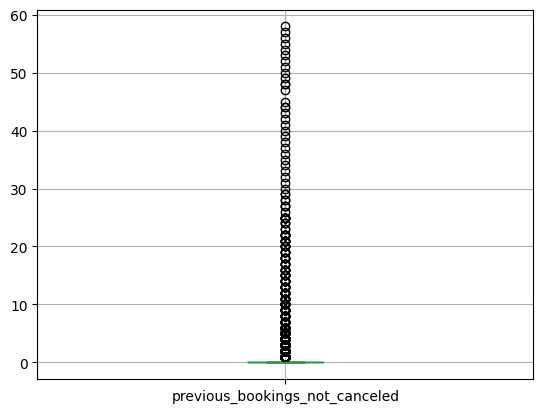

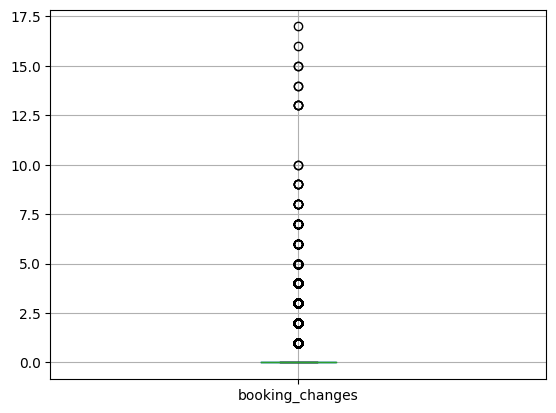

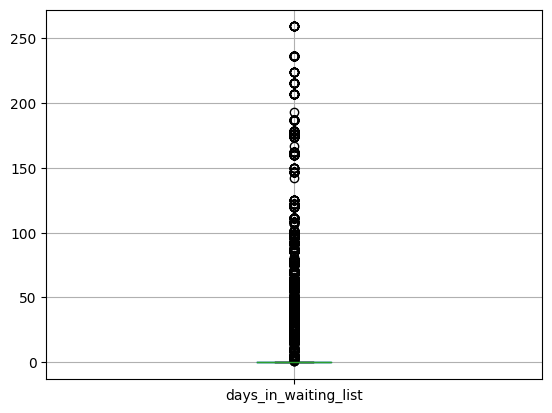

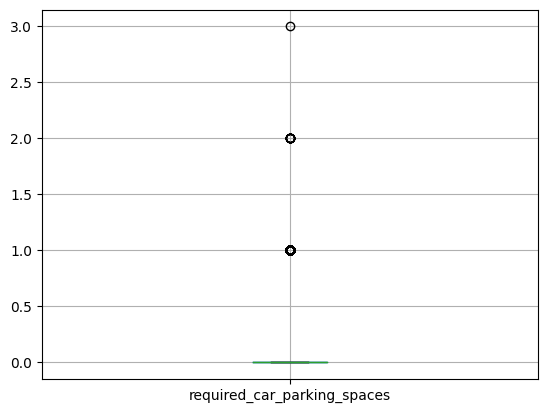

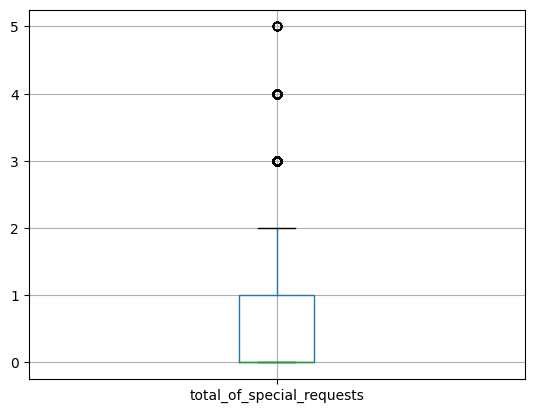

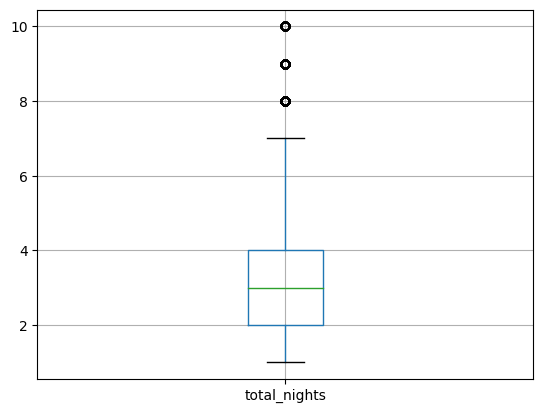

In [23]:
# просмотр распределение значений через boxplot

# значение, которые просматриваться не будут
stop_view = ['id', 'is_canceled', 'arrival_date_month', 'meal', 'country',
                 'distribution_channel','reserved_room_type','customer_type',
            'is_repeated_guest', 'arrival_date_year']

# список просматриваемых значений
view_list = [x for x in train.columns if x not in stop_view]


for i in view_list:
    train.boxplot(i)
    plt.show()
    
    

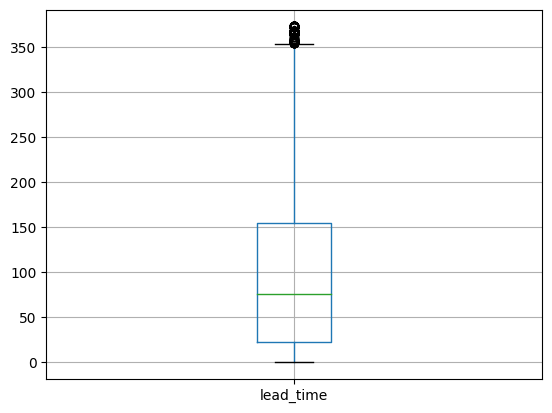

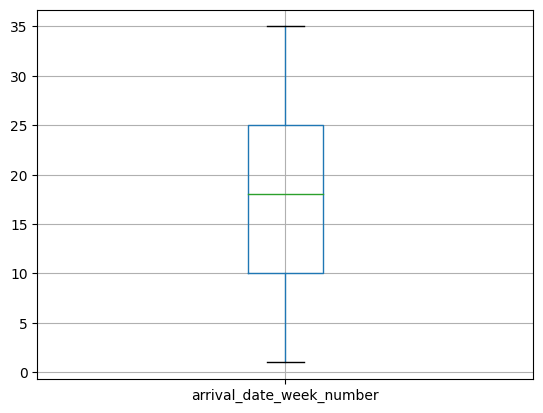

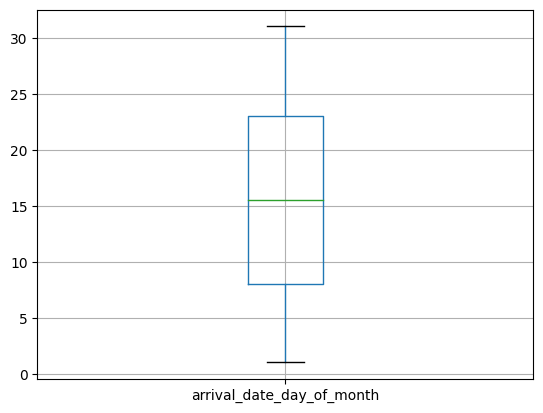

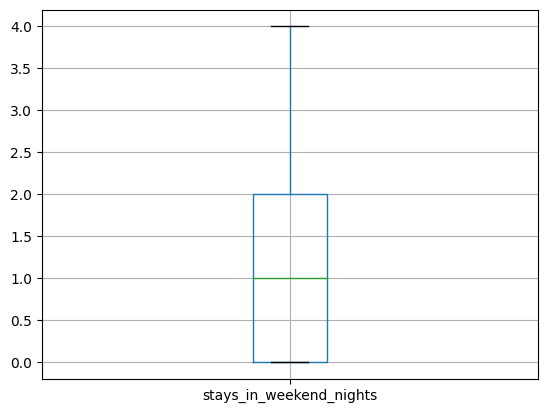

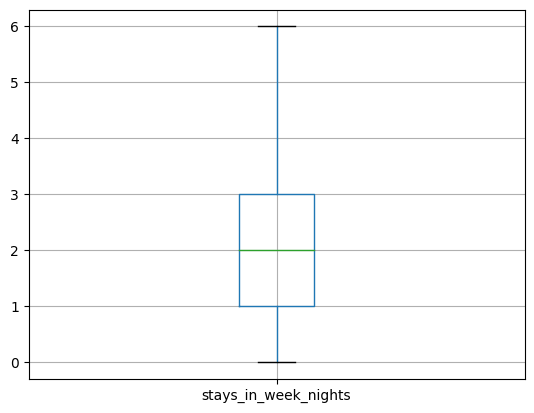

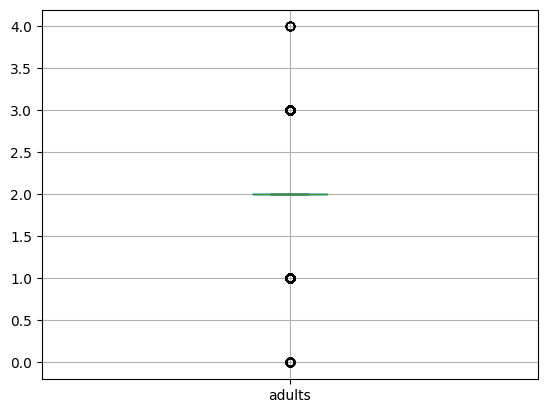

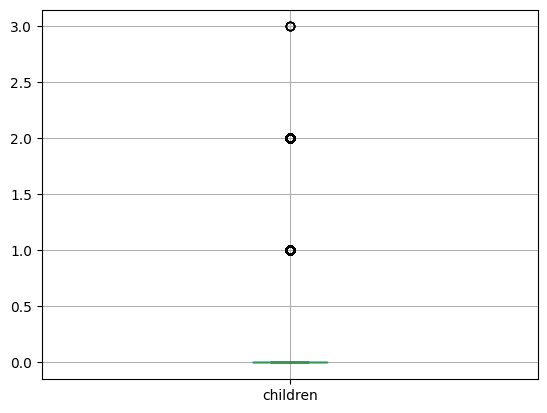

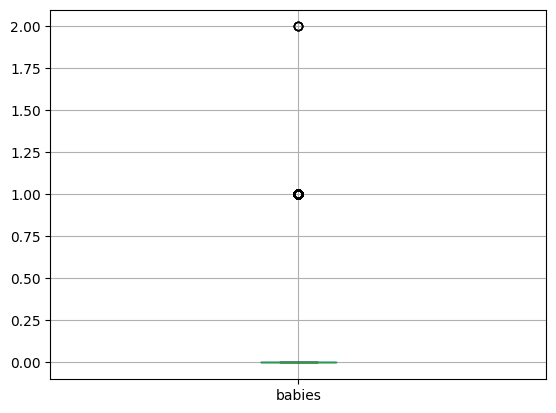

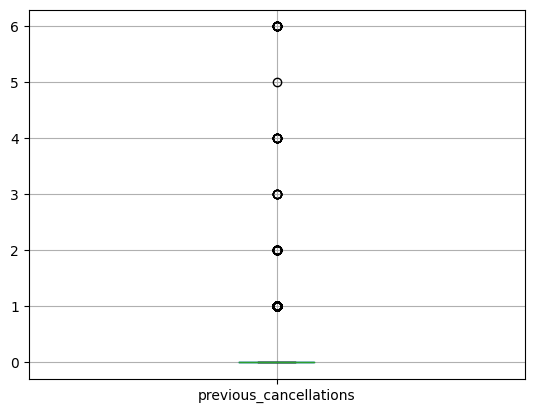

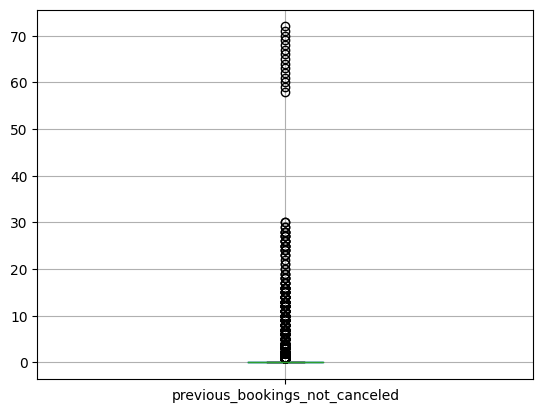

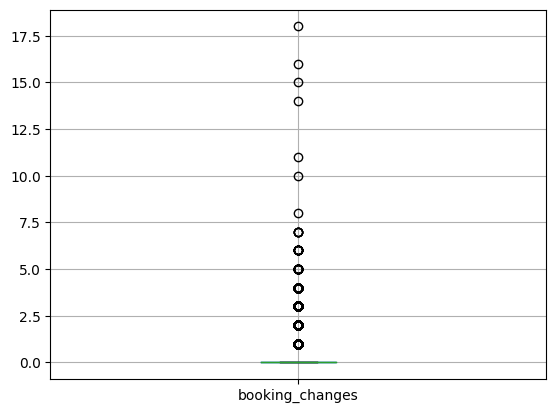

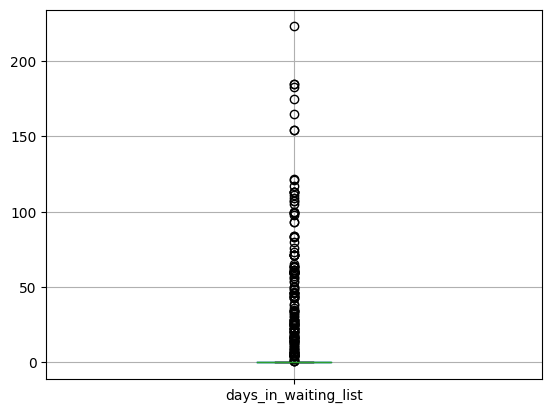

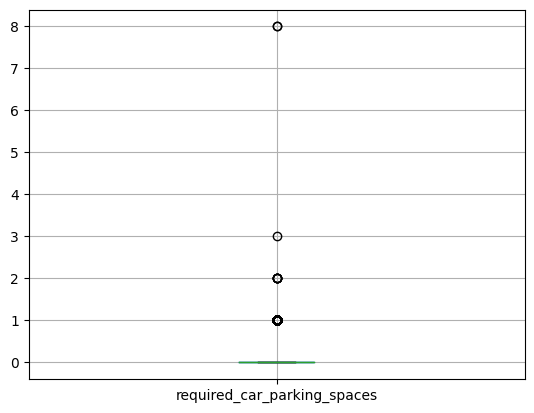

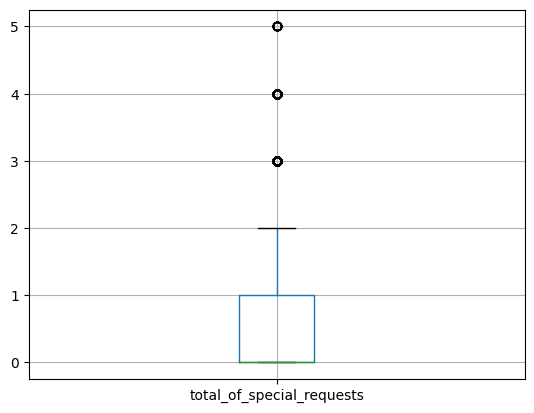

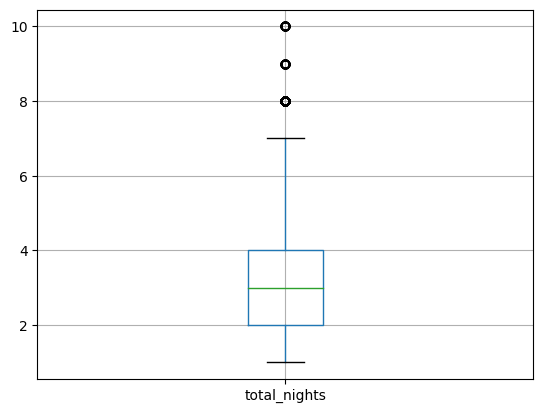

In [24]:
# аналогичное действие для датасета test

stop_view = ['id', 'is_canceled', 'arrival_date_month', 'meal', 'country',
                 'distribution_channel','reserved_room_type','customer_type',
            'is_repeated_guest', 'arrival_date_year']

view_list = [x for x in test.columns if x not in stop_view]
    
for i in view_list:
    test.boxplot(i)
    plt.show()
        

**Вывод:** В датасетах train и test 65229 и 32412 строчек соответственно. Пропусков не обнаружено. Удалены лишние пробелы в категориальных значениях. Из матрицы корреляции видно что существует сильная взаимосвязь между id и is_canceled, что означает что значения в датасете не перемешаны (при обучении модели необходимо будет обратить внимание на перемешивание данных). Чаще всего отменяют бронирование у номеров класса A, самый популярный месяца для отмены – летний период. Из кол-ва ночей чаще всего отменяют бронирование 1-3 ночи. Более 75% всех бронирования отменятся, если они сделаны за 292 – 370 дней (практически за 1 год до заезда).

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [25]:
# словарь комнат с ценами за ночь и 1 обсулживанием номера
coast = {'A': [1000, 400], 'B':[800, 350],
        'C':[600, 350], 'D':[550, 150],
        'E':[500, 150], 'F':[450, 150],
        'G':[350, 150]}

# переодичность уборки в номере
clean_day = 2 

# месяца с увеличенным коэффицентами
coef_20 = ['March', 'April', 'May', 'September', 'October', 'November']
coef_40 = ['June', 'July','August']

total = 0

room_type = test['reserved_room_type'].unique()
month_for_coef =  test['arrival_date_month'].unique()

for i in room_type:
    
    return_price = coast[i]
    
    for x in month_for_coef:
        
        if x in coef_20:
            coef = 1.20
        elif x in coef_40:
            coef = 1.40
        else:
            coef = 1   
        
        type_0 = test.loc[(test['is_canceled'] == 0) & (test['arrival_date_month'] == x) & \
                             (test['reserved_room_type'] == i)]['total_nights']
                          
        type_sum_0 = type_0.sum()                
        type_count_0 = type_0.count()                     
                              
        #сумма всего за номер
        total += type_sum_0 * return_price[0] * coef 
        
        #минус разовая уборка и уборка раз в 2 дня
        total -=  (type_count_0 * return_price[1]) + (sum([x // 2 for x in type_0]) * return_price[1])
                              
        type_count_1 = test.loc[(test['is_canceled'] == 1) & (test['arrival_date_month'] == x) & \
                             (test['reserved_room_type'] == i)]['total_nights'].count()
        
        #минус отмененная бронь (кол-во) и разовая уборка
        total -=  (type_count_1 * return_price[0] * coef) + (type_count_1 * return_price[1])
        
print(f"Суммарная выручка отеля по выборке test до внедрения депозитов за весь год =  {total:,}")

TOTAL_NO_DEPOSIT = total

Суммарная выручка отеля по выборке test до внедрения депозитов за весь год =  32,582,920.0


**Вывод:** Выручка без внедрения депозитов состовляет 32,582,920

### Шаг 4. Разработка модели ML

In [26]:
def split_data_to_ml(data, to_drop, target):
    '''функция делит датасеты на параметры и таргет'''
    features = data.drop(to_drop, axis = 1)
    target = data[target]
    
    return features, target
    

In [27]:
# деление датасета на признаки и таргет
features_train, target_train = split_data_to_ml(
    train, ['id','is_canceled','country', 'arrival_date_year', 'arrival_date_month'], 'is_canceled')


In [28]:
features_train.head()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,7.0,27,1,0,1,1,0,0,BB,Direct,0,0,0,A,0,0,Transient,0,0,1
1,14.0,27,1,0,2,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,0.0,27,1,0,2,2,0,0,BB,Direct,0,0,0,C,0,0,Transient,0,0,2
3,9.0,27,1,0,2,2,0,0,FB,Direct,0,0,0,C,0,0,Transient,0,1,2
4,85.0,27,1,0,3,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,3


0    0.631391
1    0.368609
Name: is_canceled, dtype: float64


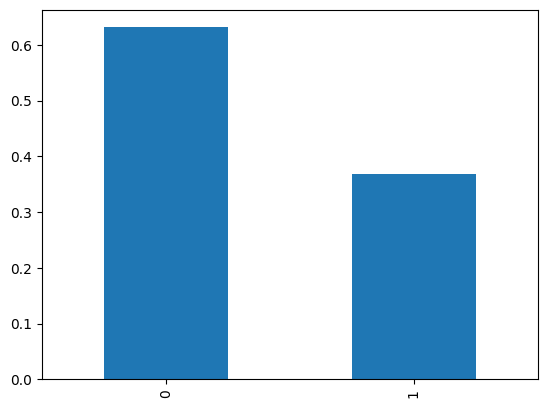

In [29]:
# распределение значений в таргете
class_frequency = target_train.value_counts(normalize= True)
print(class_frequency)

class_frequency.plot(kind='bar')
plt.show()

Наблюдается небольшой дисбаланс в распределении классов 63% на 37%. В дальнейшем возможно применить несколько способов борьбы с дисбалансом.

In [30]:
# удалим излишние данные связанные с датами и применим технику OH для кодирования
# features_train = features_train.drop(['arrival_date_month', 'distribution_channel',
#                                      'reserved_room_type', 'customer_type'], axis = 1)

# features_train = pd.get_dummies(features_train, drop_first=True)

In [31]:
# деление датасета train на тренировочную и вилдационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(
   features_train, target_train, test_size=0.30, random_state = 12345, 
    stratify = target_train, shuffle = True)


In [32]:
#категориальные признаки
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
ohe_features

['meal', 'distribution_channel', 'reserved_room_type', 'customer_type']

In [33]:
#численные признаки
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('is_repeated_guest')
num_features

['lead_time',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'total_nights']

In [34]:
# кодирование данных техникой OHE
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

# обучаем энкодер 
encoder_ohe.fit(features_train[ohe_features])

# добавляем закодированные признаки датасет

features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

# удаляем незакодированные категориальные признаки
features_train = features_train.drop(ohe_features, axis=1)

#скелер
scaler = StandardScaler()

# обучаем его 
features_train[num_features] = scaler.fit_transform(features_train[num_features])

features_train.head()


,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
48112,0.194761,-1.439437,0.246789,-0.969253,-0.165281,0.339923,-0.22615,-0.076644,0,-0.134694,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10971,-1.001373,-1.439437,-0.096170,-0.969253,0.572568,-1.742579,-0.22615,-0.076644,0,-0.134694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
43383,-0.398106,1.161076,0.246789,-0.969253,1.310417,0.339923,-0.22615,-0.076644,0,-0.134694,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
22325,-0.127675,1.235376,1.275666,0.201760,-0.165281,-1.742579,-0.22615,-0.076644,0,-0.134694,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17697,-0.834955,0.120871,-0.324810,1.372773,0.572568,0.339923,-0.22615,-0.076644,0,-0.134694,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [35]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую

features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[ohe_features])

features_valid = features_valid.drop(ohe_features, axis=1)

# скелером масштабируем тестовую
features_valid[num_features] = scaler.transform(
    features_valid[num_features]
)

# смотрим на результат
features_valid.head()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
10597,-1.001373,-1.588037,-1.582326,-0.969253,-0.903130,-1.742579,-0.22615,-0.076644,0,-0.134694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
44807,2.295797,0.418072,-0.782088,0.201760,-0.165281,0.339923,-0.22615,-0.076644,0,0.923664,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
50127,0.537999,-1.067935,0.818387,1.372773,-0.903130,0.339923,-0.22615,-0.076644,0,-0.134694,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13937,0.028342,0.195171,0.361109,0.201760,-0.165281,0.339923,-0.22615,-0.076644,0,-0.134694,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
30953,1.026854,0.046570,-1.468007,-0.969253,1.310417,0.339923,-0.22615,-0.076644,0,-0.134694,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [36]:
#количество признаков
features_train.shape, features_valid.shape

((45660, 31), (19569, 31))

In [37]:
#признаки в тренировочной и тестовой выборках
(features_train.columns != features_valid.columns).sum()

0

Аналогичные процедуры для тестовой выборки

In [38]:
# деление датасета на признаки и таргет
features_test, target_test = split_data_to_ml(
    test, ['id','is_canceled','country', 'arrival_date_year', 'arrival_date_month'], 'is_canceled')

features_test, target_test = shuffle(features_test, target_test, random_state=12345)

0    0.611533
1    0.388467
Name: is_canceled, dtype: float64


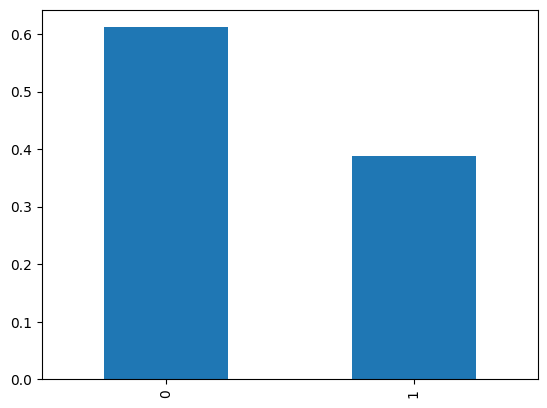

In [39]:
# распределение значений в таргете test
class_frequency = target_test.value_counts(normalize= True)
print(class_frequency)

class_frequency.plot(kind='bar')
plt.show()

В тестовом датасете аналогично наблюдается небольшой дисбаланс классов.

In [40]:
# деление датасета на признаки и таргет
features_test = features_test.astype({'lead_time': 'int64', 'adults': 'int64','children': 'int64',
             'babies': 'int64'})

In [41]:
ohe_features = features_test.select_dtypes(include='object').columns.to_list()

In [42]:
# кодирование данных техникой OHE
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])

# удаляем незакодированные категориальные признаки 
features_test = features_test.drop(ohe_features, axis=1)

# скелер
scaler = StandardScaler()

# обучаем его н
features_test[num_features] = scaler.fit_transform(features_test[num_features])

# результат
features_test.head()



,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
16130,2.836944,1.002038,-1.557893,1.326620,-0.247312,0.288961,-0.243883,-0.0729,0,-0.06428,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8160,-0.792870,-1.613127,0.039133,1.326620,1.934271,0.288961,-0.243883,-0.0729,0,-0.06428,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15097,0.871758,0.675142,-0.531233,1.326620,0.479883,0.288961,-0.243883,-0.0729,0,-0.06428,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15841,0.467161,0.893073,1.293939,-1.017001,0.479883,0.288961,-0.243883,-0.0729,0,-0.06428,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
836,-0.284234,-0.305544,-0.074940,1.326620,-0.974506,-1.754634,2.667625,-0.0729,0,-0.06428,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [45]:
def to_pipeline(model, features_train, target_train, features_valid, target_valid):
    '''Функция для создания pipeline и оценки кросс валидацией'''
    model_pipeline = make_pipeline(
        RandomUnderSampler(random_state=12345),
        model
    )
    
    cv_results = cross_validate(
        model_pipeline, features_train, target_train, scoring="balanced_accuracy",
        return_train_score=True, return_estimator=True,
        n_jobs=-1
    )
    print(
        f"Balanced accuracy среднее +/- стандартное отклонение: "
        f"{cv_results['test_score'].mean():.3f} +/- "
        f"{cv_results['test_score'].std():.3f}"
    )

    scores = []
    for fold_id, cv_model in enumerate(cv_results["estimator"]):
        scores.append(
            balanced_accuracy_score(
                target_valid, cv_model.predict(features_valid)
           )
        )
    print(
        f"Balanced accuracy среднее +/- стандартное отклонениe: "
        f"{np.mean(scores):.3f} +/- {np.std(scores):.3f}"
    )
    
    return model_pipeline
    

In [46]:
%%time
# модель дерева решений 

model_dtf = DecisionTreeClassifier(random_state = 12345)

model = to_pipeline(model_dtf, features_train, target_train, features_valid, target_valid)

# комбинаций гиперпараметров
param_grid = {
    'decisiontreeclassifier__max_depth': range(1, 9),
    'decisiontreeclassifier__criterion': ['gini', 'entropy', 'log_loss'],
    'decisiontreeclassifier__class_weight': ['None', 'balanced'],
    'decisiontreeclassifier__splitter':['best', 'random']
}

# подбор гиперпараметров
gs_dtf = RandomizedSearchCV(
    model, 
    param_distributions=param_grid, 
    scoring="balanced_accuracy", 
    n_jobs=-1, 
    random_state=12345
)

# фит модели
gs_dtf.fit(features_train, target_train)

print()
print(f'best_score: {gs_dtf.best_score_}')
print()
print(f'best_params: {gs_dtf.best_params_}')



Balanced accuracy среднее +/- стандартное отклонение: 0.787 +/- 0.003
Balanced accuracy среднее +/- стандартное отклонениe: 0.791 +/- 0.001

best_score: 0.7603523348532126

best_params: {'decisiontreeclassifier__splitter': 'best', 'decisiontreeclassifier__max_depth': 6, 'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__class_weight': 'balanced'}
CPU times: total: 1.2 s
Wall time: 2.75 s


In [47]:
%%time
# модель случайного леса

model_rfc = RandomForestClassifier(random_state = 12345)

model = to_pipeline(model_rfc, features_train, target_train, features_valid, target_valid)

# комбинаций гиперпараметров
param_grid = {
    'randomforestclassifier__max_depth': range(1, 16),
    'randomforestclassifier__n_estimators': range(10, 111, 10),
    'randomforestclassifier__class_weight': ['None', 'balanced', 'balanced_subsample'],
    'randomforestclassifier__bootstrap':[False, True],

}

# подбор гиперпараметров
gs_rfc = RandomizedSearchCV(
    model, 
    param_distributions=param_grid, 
    scoring="balanced_accuracy", 
    n_jobs=-1, 
    random_state=12345
)

# фит модели
gs_rfc.fit(features_train, target_train)

print()
print(f'best_score: {gs_rfc.best_score_}')
print()
print(f'best_params: {gs_rfc.best_params_}')

Balanced accuracy среднее +/- стандартное отклонение: 0.829 +/- 0.001
Balanced accuracy среднее +/- стандартное отклонениe: 0.829 +/- 0.001

best_score: 0.8089203801630953

best_params: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_depth': 14, 'randomforestclassifier__class_weight': 'balanced_subsample', 'randomforestclassifier__bootstrap': True}
CPU times: total: 5.86 s
Wall time: 25.6 s


In [48]:
%%time
# модель логистической регрессии
model_lr = LogisticRegression(random_state = 12345)

model = to_pipeline(model_lr, features_train, target_train, features_valid, target_valid)

# комбинаций гиперпараметров
param_grid = {
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet', None],
    'logisticregression__class_weight': ['None', 'balanced'],
    'logisticregression__max_iter': range(100, 500, 100),
    'logisticregression__multi_class': ['auto', 'ovr', 'multinomial']
}

# подбор гиперпараметров
gs_lr = RandomizedSearchCV(
    model, 
    param_distributions=param_grid, 
    scoring="balanced_accuracy", 
    n_jobs=-1, 
    random_state=12345
)
# фит модели
gs_lr.fit(features_train, target_train)

print()
print(f'best_score: {gs_lr.best_score_}')
print()
print(f'best_params: {gs_lr.best_params_}')

Balanced accuracy среднее +/- стандартное отклонение: 0.743 +/- 0.004
Balanced accuracy среднее +/- стандартное отклонениe: 0.737 +/- 0.001

best_score: 0.7438352800234116

best_params: {'logisticregression__penalty': None, 'logisticregression__multi_class': 'ovr', 'logisticregression__max_iter': 200, 'logisticregression__class_weight': 'balanced'}
CPU times: total: 1.55 s
Wall time: 4.85 s


In [49]:
def metrixs(features, target, predict, model):
    '''исследование метрики при использовании оптимальной модели МО'''
   
    #recall_score
    recall_score = (target, predict)

    #  f1 метрика
    f1 = f1_score(target, predict)
    
    #   auc_roc метрика
    probabilities = model.predict_proba(features)
    probabilities_one = probabilities[:, 1]
    
    auc_roc = roc_auc_score(target, probabilities_one) 
    
    # матрица ошибок 
    conf_matrix = confusion_matrix(target, predict)
    
    print('recall_score:', np.mean(recall_score))
    print("F1-мера:", f1)
    print("auc_roc:", auc_roc)
    print('Матрица ошибок:','\n', conf_matrix)

In [50]:
def roc_auc_plt(model, features_test, target_test):
    
    """Строит график auc-roc кривой"""
    
    #запись результатов модели при изменении порогов положительного ответа
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]

    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

    plt.figure()

    # построение графика модели
    plt.step(fpr, tpr)

    # ROC-кривая случайной модели
    plt.plot([0,1], linestyle = '--')

    plt.ylim([0, 1])
    plt.xlim([0, 1])

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")

    plt.show()

recall_score: 0.36916882636060716
F1-мера: 0.63340437089967
auc_roc: 0.7970084259523418
Матрица ошибок: 
 [[16060  3761]
 [ 5012  7579]]


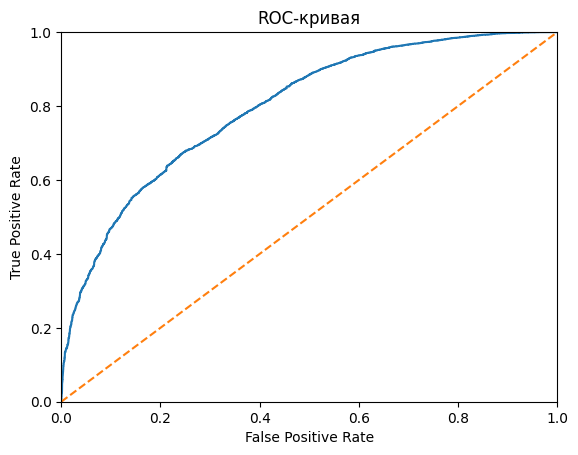

In [51]:
# лучшая модель при оценке по кросс валидации
predict_rfc = gs_rfc.predict(features_test)
metrixs(features_test, target_test, predict_rfc, gs_rfc)
roc_auc_plt(gs_rfc, features_test, target_test)

**Вывод:** Самой лучшей моделью обучения была выбрана модель случайного леса исходя из оценки кросс-валидации при обучении и метрики auc_roc, т.к. по данной метрике можно просматривать изменения значений False positive и True Positive

### Шаг 5. Опишите портрет «ненадёжного» клиента

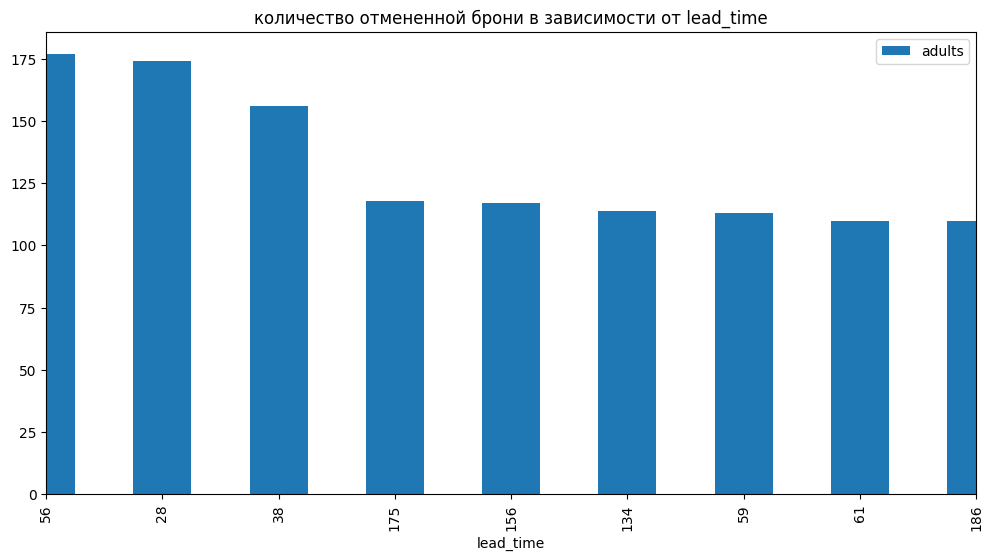

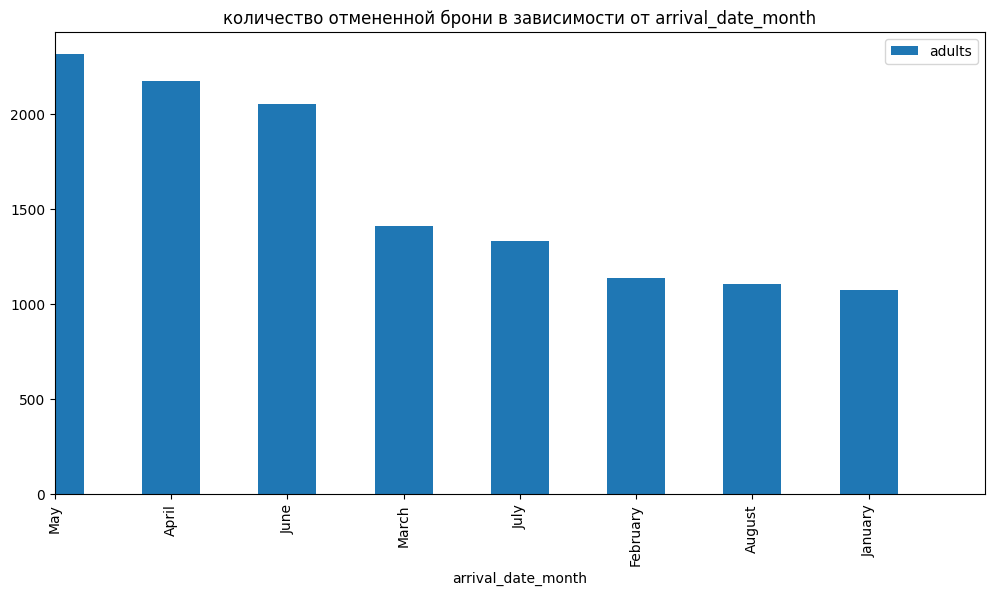

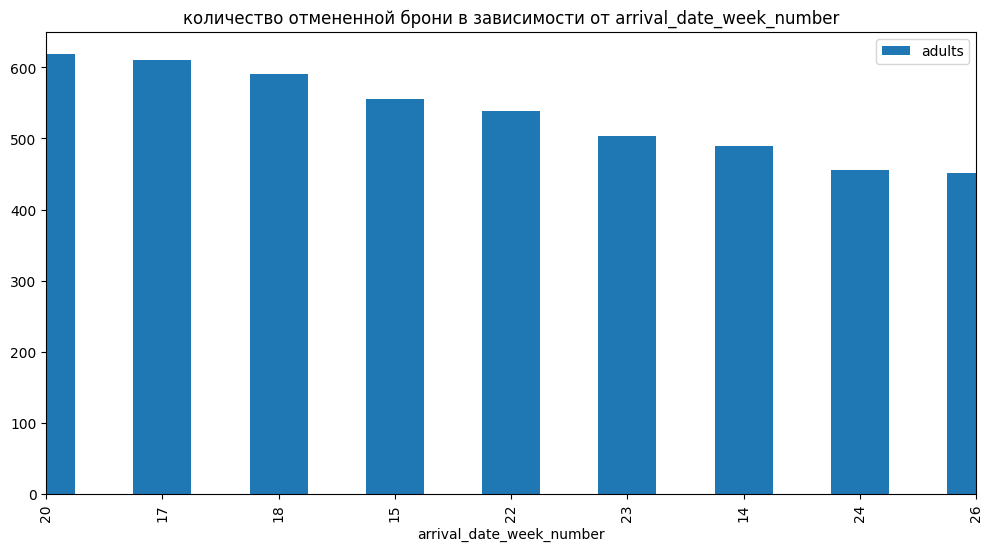

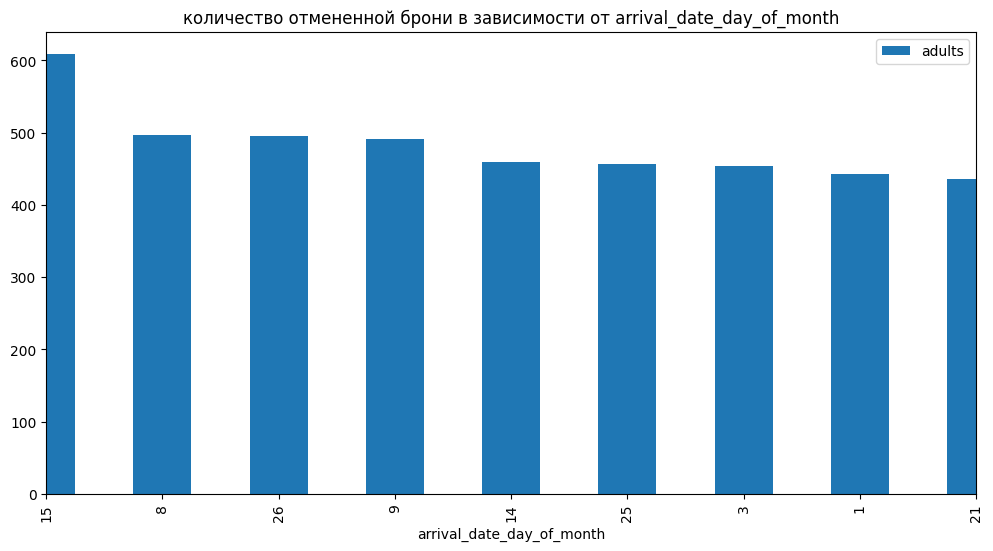

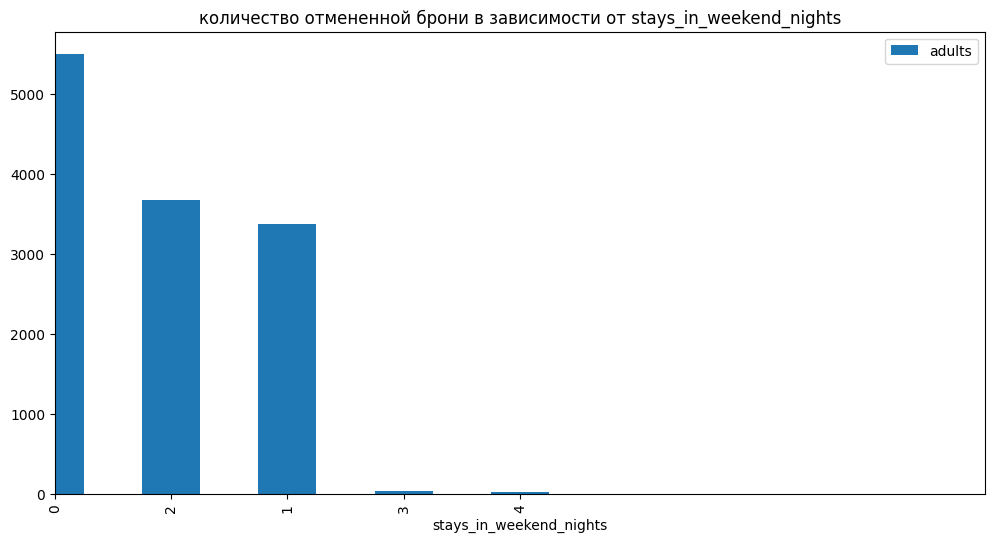

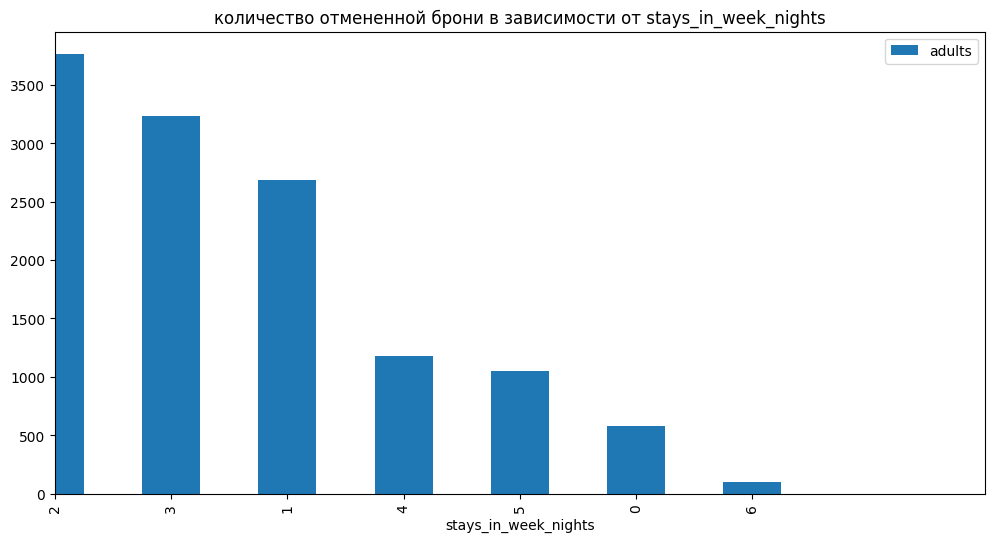

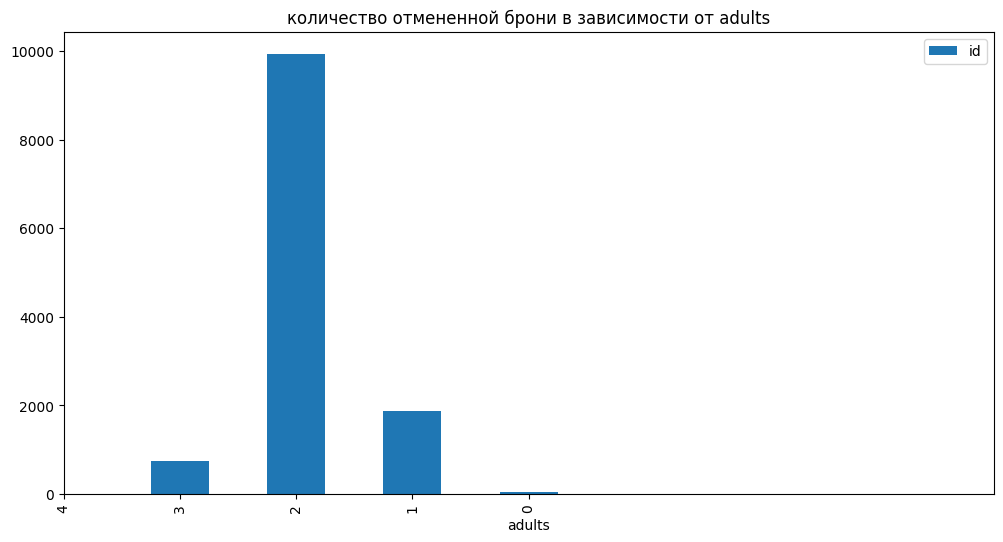

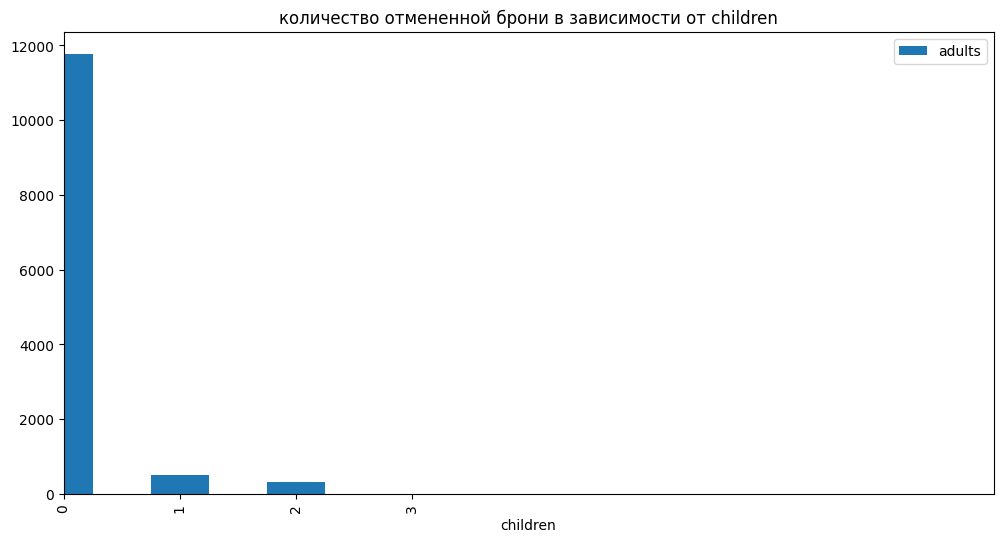

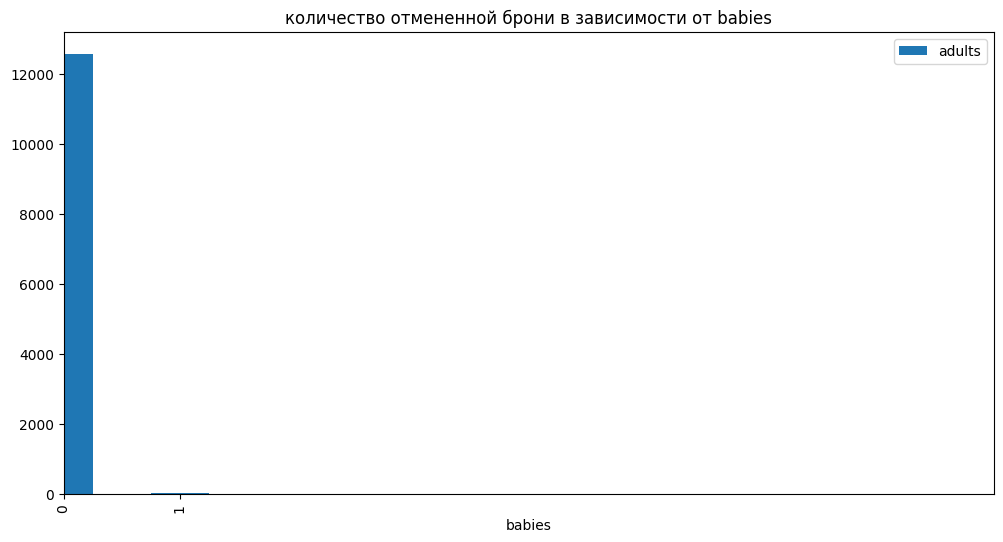

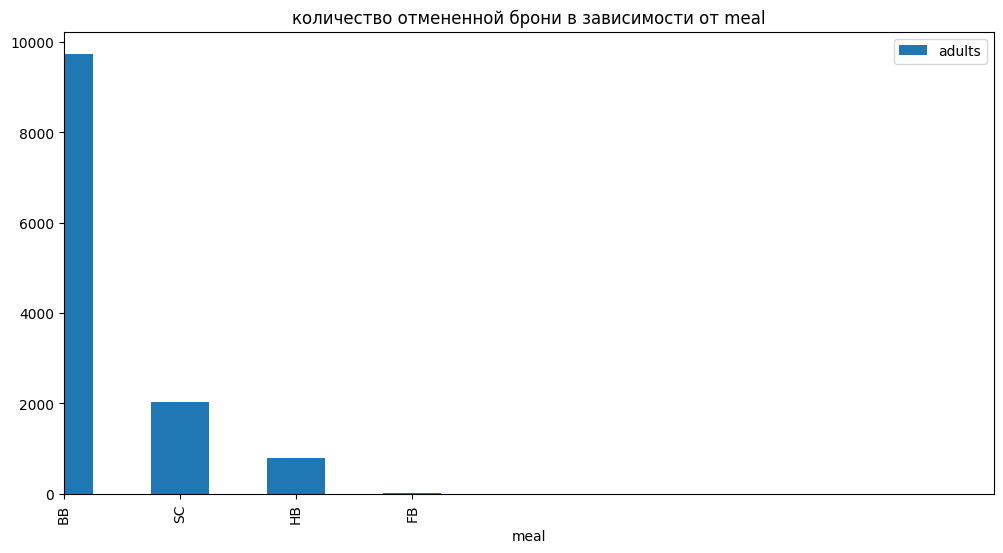

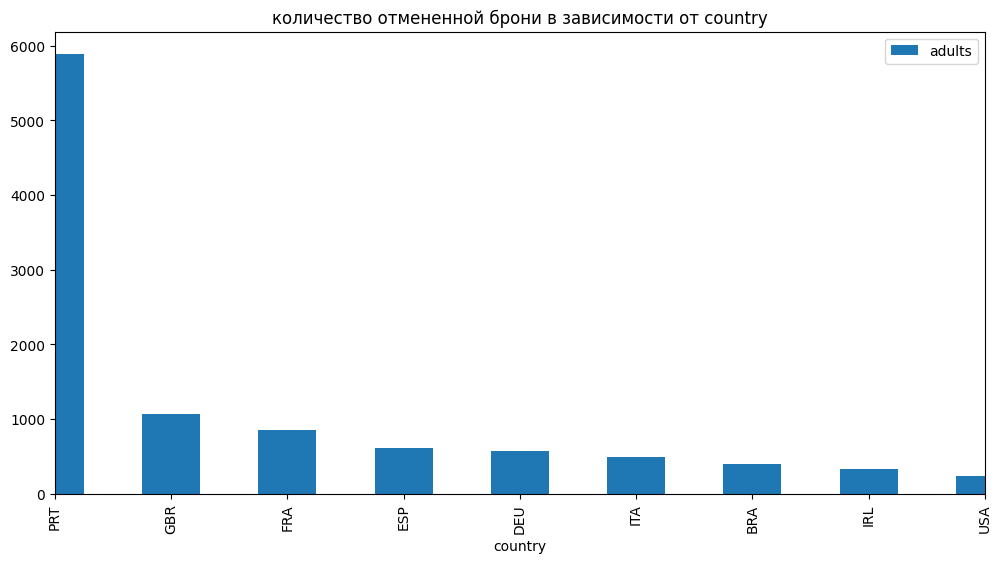

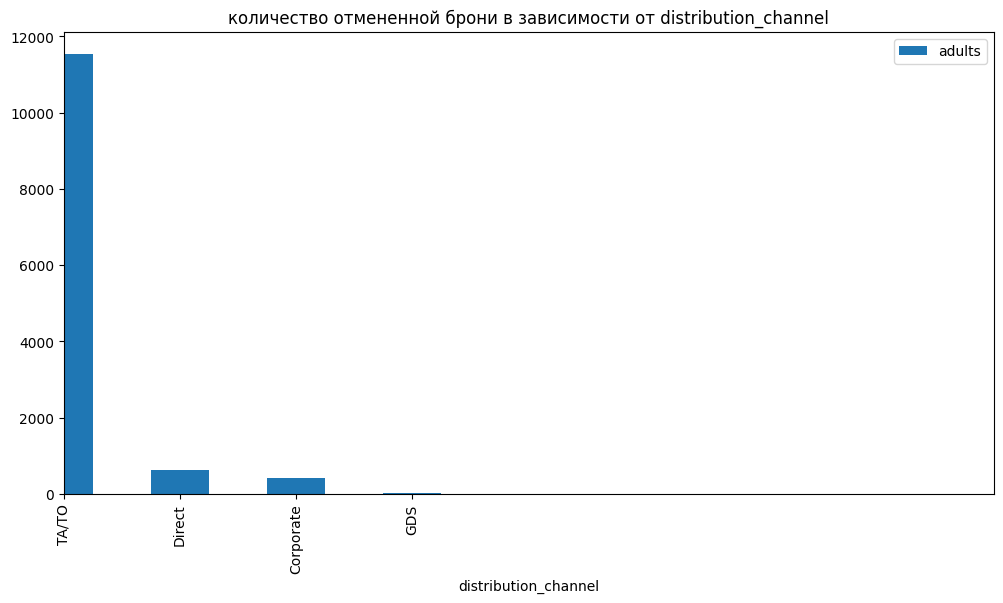

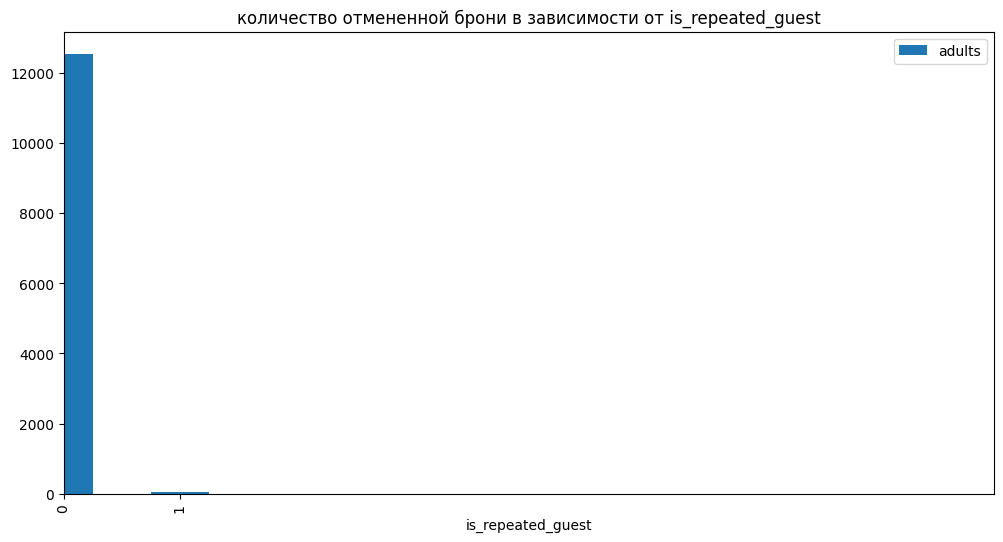

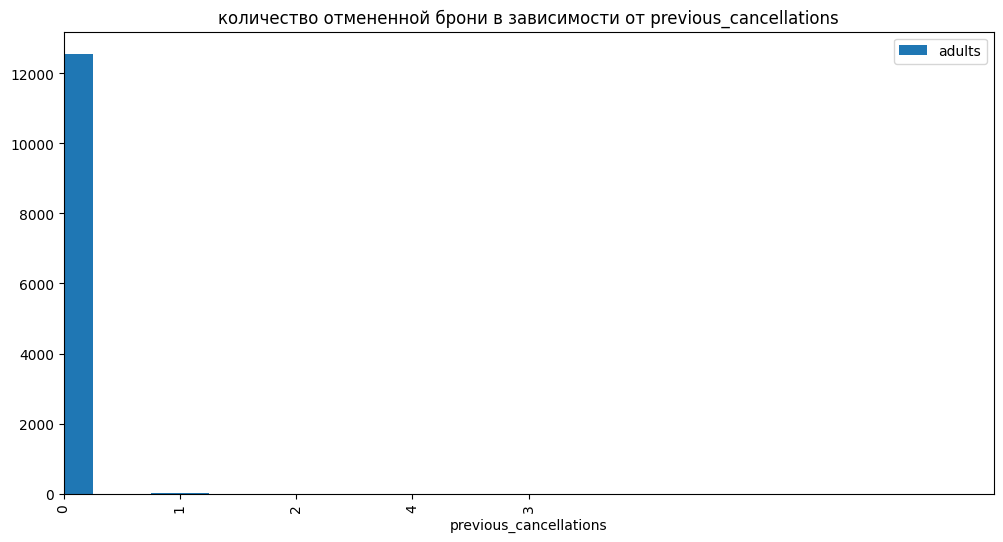

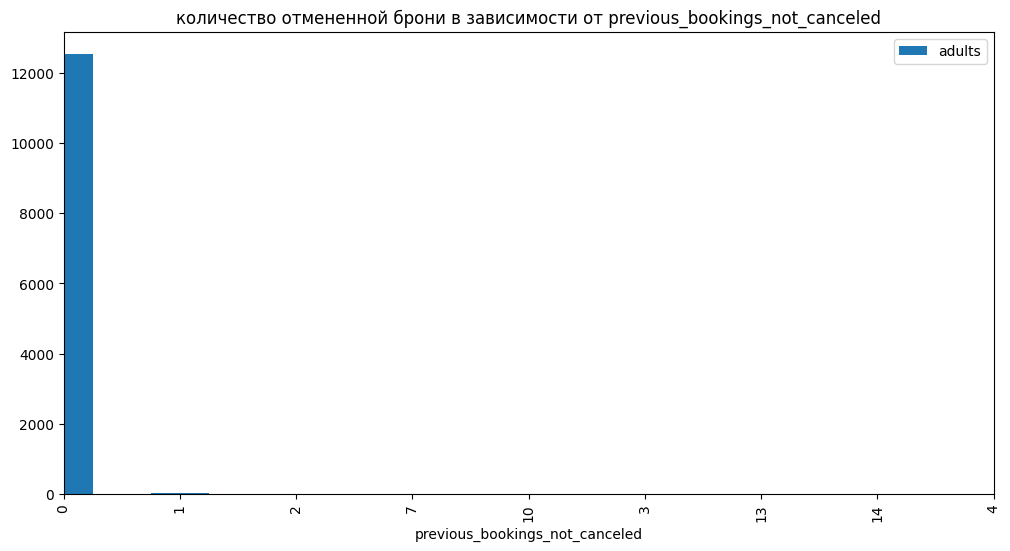

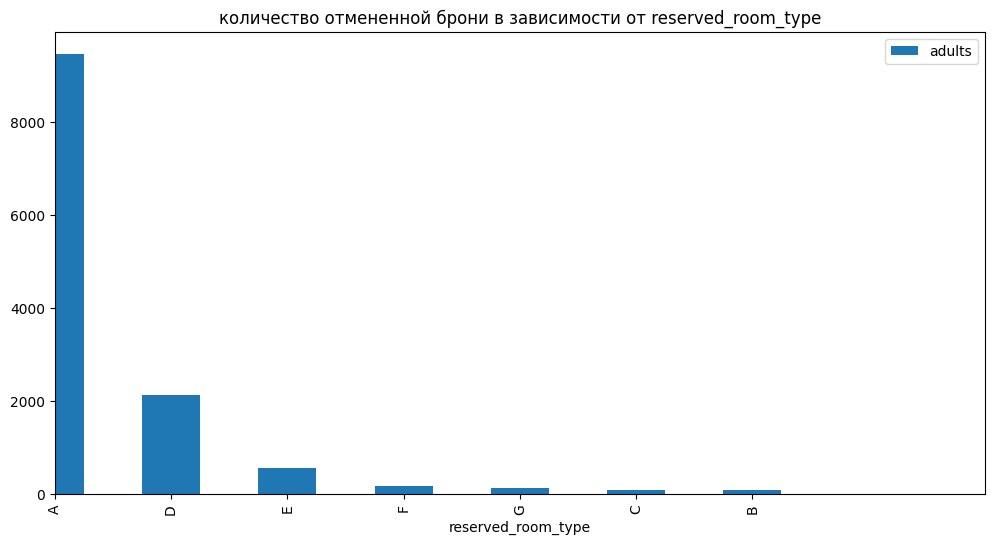

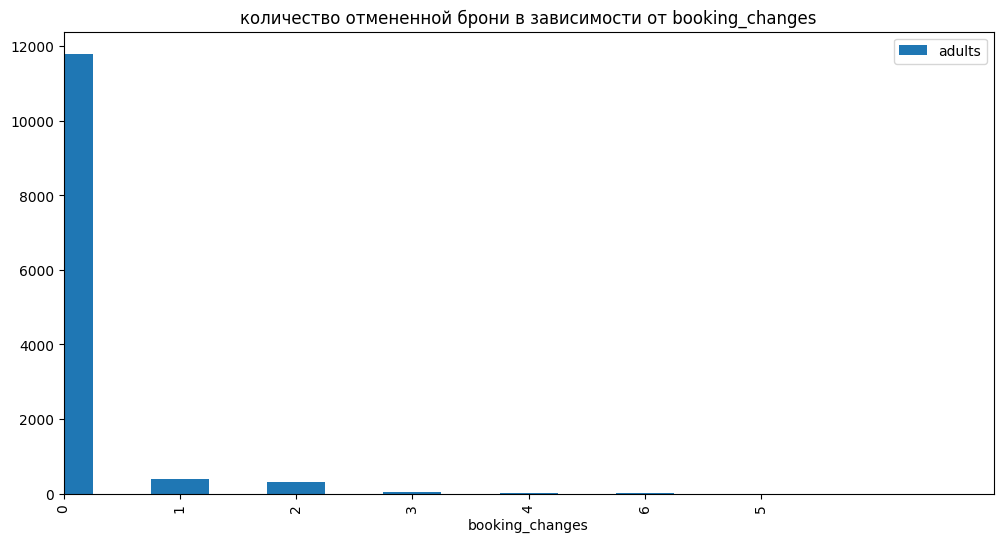

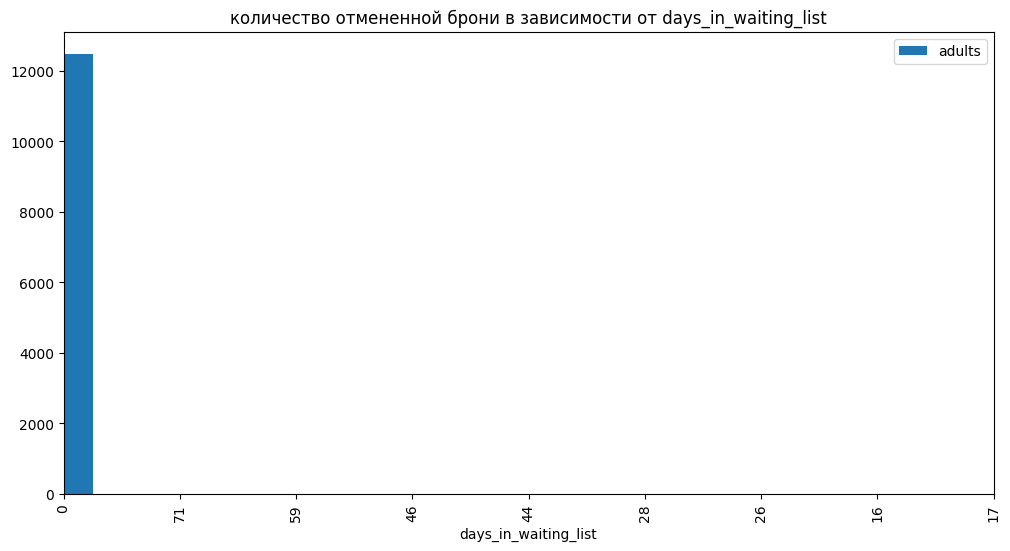

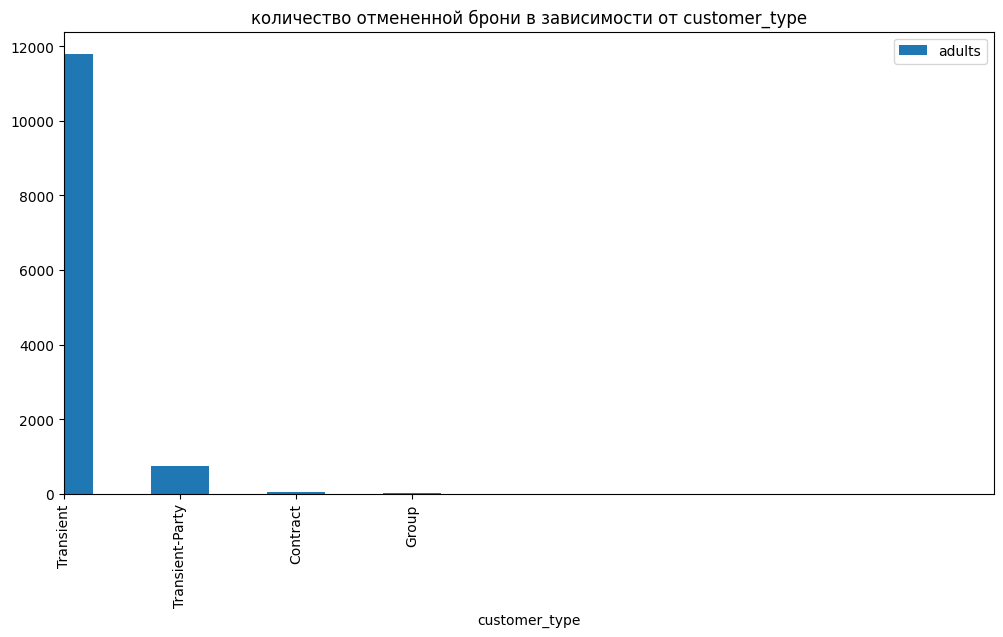

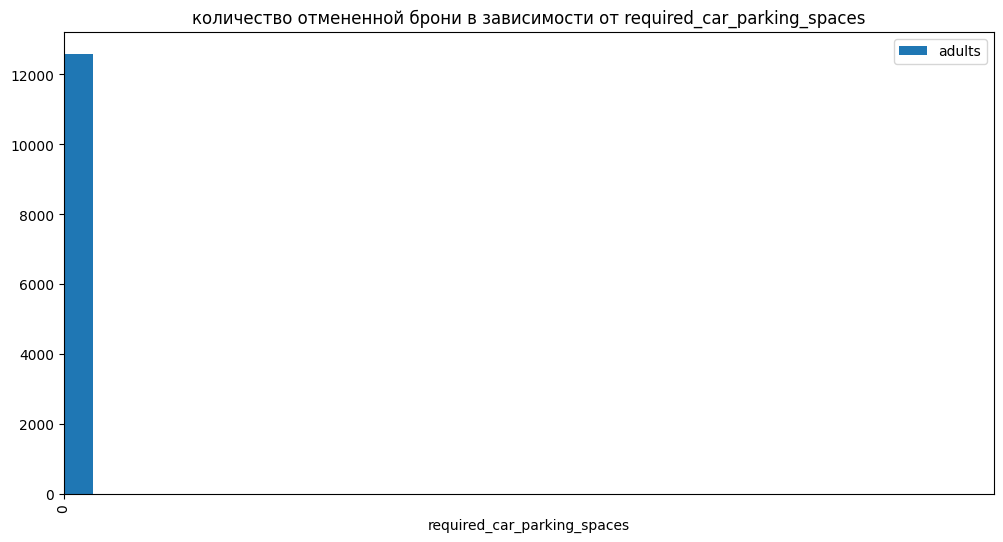

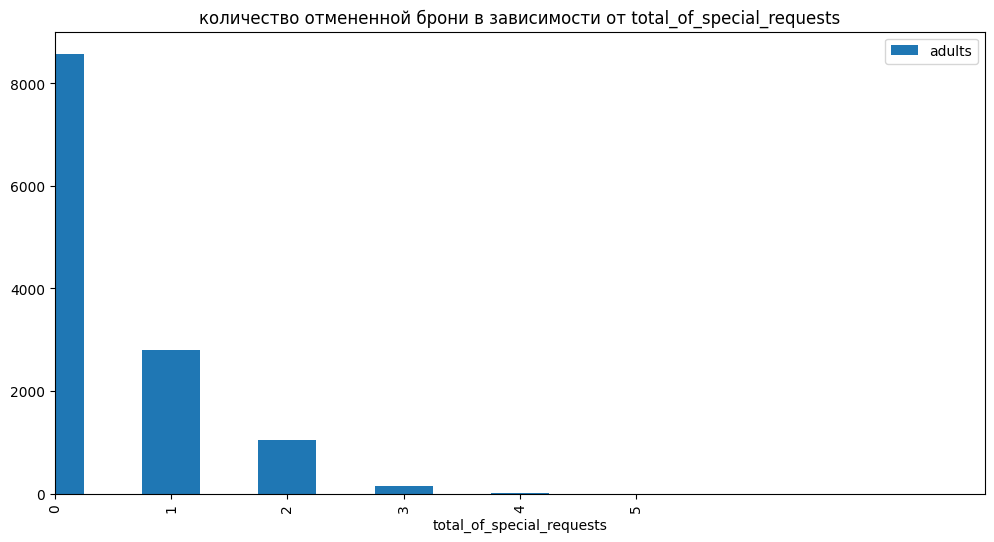

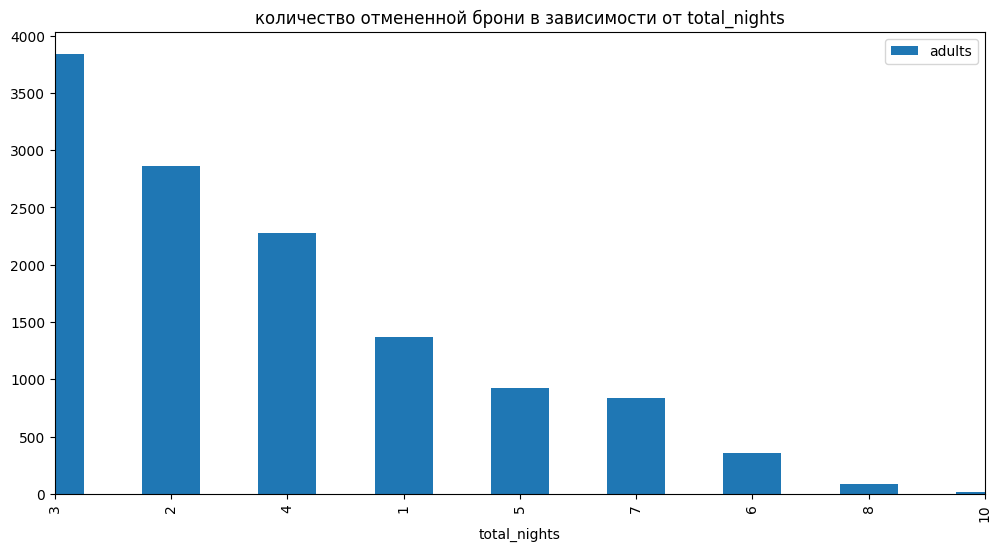

In [52]:
# изучение показателей клиентов отменивших бронь

columns = test.columns

for i in columns:
    if i in ['is_canceled','id',
            'arrival_date_year']:
        continue
    if i == 'adults':
        test.loc[test['is_canceled'] == 1].groupby(i).agg({'id':'count'}).\
        sort_values(by = 'adults', ascending = False).plot(kind = 'bar', figsize = (12,6))
        plt.xlim([0,8])
        plt.title(f'количество отмененной брони в зависимости от {i}')
        plt.show()
    try:
        test.loc[test['is_canceled'] == 1].groupby(i).agg({'adults':'count'}).\
        sort_values(by = 'adults', ascending = False).plot(kind = 'bar', figsize = (12,6))
        plt.xlim([0,8])
        plt.title(f'количество отмененной брони в зависимости от {i}')
        plt.show()
    except:
        continue

**Вывод:** 
> Клиент, который скорее всего откажется от брони:
    
    -	заказ был сделан в период от 25-150 дней до заезда
    -	дата заезда с марта до конца лета
    -	на 1 – 4 дня в будние дни и на 1-3 дня в выходные
    -	в группе из 2 человек
    -	Без детей
    -	Включен завтрак
    -	Из Португалии 
    -	канал дистрибуции - TA/TO
    -	Комната класса А
    -	customer_type – Transient
    -	парковка не требуется
    -	количество специальных условий от 0 до 1
 

### Рассчет прибыль при внедрении депозитов

In [53]:
test_coast = test.copy()
test_coast['predict_canceled'] = predict_rfc

In [54]:
def help_sum(total, target, predict, coef, x, i, return_price):
    '''функция группировки и суммирования по указанным значениям'''
    
    loc_data = test_coast.loc[(test_coast['is_canceled'] == target) & \
                                (test_coast['arrival_date_month'] == x) & \
                                (test_coast['reserved_room_type'] == i) & \
                                (test_coast['predict_canceled'] == predict)]['total_nights']

    data_sum = loc_data.sum()                              
    data_count = loc_data.count()                     
    
    #сумма всего за номер
    total += data_sum * return_price[0] * coef
    #минус разовая уборка и уборка раз в 2 дня
    total -=  (data_count * return_price[1]) + (sum([x // 2 for x in loc_data]) * return_price[1])
    
    return total

In [55]:
def help_sum_minus(total, target, predict, coef, x, i, return_price, canceled = 1):
    '''функция группировки и вычитания по указанным значениям'''
    
    loc_data = test_coast.loc[(test_coast['is_canceled'] == target) & \
                                (test_coast['arrival_date_month'] == x) & \
                                (test_coast['reserved_room_type'] == i) & \
                                (test_coast['predict_canceled'] == predict)]['total_nights']                             
    data_count = loc_data.count()                     

    #минус разовая уборка и уборка раз в 2 дня
    total -=  (data_count * return_price[0] * coef) * canceled + (data_count * return_price[1])
    return total

In [56]:
# словарь комнат с ценами за ночь и 1 обсулживанием номера
coast = {'A': [1000, 400], 'B':[800, 350],
        'C':[600, 350], 'D':[550, 150],
        'E':[500, 150], 'F':[450, 150],
        'G':[350, 150]}

# переодичность уборки в номере
clean_day = 2 

# месяца с увеличенным коэффицентами
coef_20 = ['March', 'April', 'May', 'September', 'October', 'November']
coef_40 = ['June', 'July','August']

total = 0

room_type = test_coast['reserved_room_type'].unique()
month_for_coef =  test_coast['arrival_date_month'].unique()

for i in room_type:
    
    return_price = coast[i]
    
    for x in month_for_coef:
        
        if x in coef_20:
            coef = 1.20
        elif x in coef_40:
            coef = 1.40
        else:
            coef = 1   
        
        total = help_sum(total, 0, 0, coef, x, i, return_price)
        total = help_sum(total, 0, 1, coef, x, i, return_price)
        total = help_sum_minus(total, 1, 1, coef, x, i, return_price, 0.8)
        total = help_sum_minus(total, 1, 0, coef, x, i, return_price)

total -=  TOTAL_NO_DEPOSIT + 400_000        

print(f"Суммарная выручка отеля по выборке test_coast до внедрения депозитов за весь год =  {total:,}")

Суммарная выручка отеля по выборке test_coast до внедрения депозитов за весь год =  568,292.0


### Шаг 6. Напишите общий вывод

<div style="border:solid steelgreen 4px; padding: 20px; border-radius: 15px">
<h1>Итог:</h1>

>В ходе работы были выполнены следующие операции:
>>- Изучена общая информация о представленном датасете
>>- Изучены данные в предоставленных датасетах
>>- Подготовка датасета для обучения моделей МО
>>- Исследованы лучшие результаты разных моделей МО
>>- Выбрана лучшая модель МО при использовании кросс-валидации и пайплайнов
>>- Описаны критерии не надежного клиента
>>- Рассчитана выручка от внедрения депозитов
 
> В ходе исследования была выявлена самая лучшая модель для решения задачи классификации (отменит ли клиент бронь в отеле или нет) - "Случайный лес". Параметры auc-roc данной модели составляет 0.79. Данная метрика была выбрана по причине того, что она вычисляется из показателей True Positive и False Positive.
Суммарная разница между системами (депозит и без депозита) с учетом затрат на разработку систему составила 568,292.0 тыс. то есть в течении года затраты на разработку системы окупятся за счет введения депозитов.





    